In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split,StratifiedKFold, GridSearchCV
from sklearn.feature_selection import RFECV, SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report

#import warnings
#warnings.filterwarnings('ignore')
#pd.options.display.max_columns = None

### Import Data

In [2]:
# data source: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

# read csv data into a data frame
df = pd.read_csv("weatherAUS.csv")
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

### Data Pre-Processing

#### Add New Column(s)

In [4]:
# convert Date column from string to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# convert Date column to Month
df['Month'] = pd.DatetimeIndex(df['Date']).month

# drop date column
df = df.drop(columns=['Date'])

df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,12
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,12
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,12
3,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,12
4,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,12


#### Missing Data

In [5]:
# calculate percentage of missing values in each column
missing_pct = 100 - ((df.count().sort_values()/len(df))*100)
missing = pd.DataFrame(missing_pct)
missing.columns =  ['Percent Missing']
missing

,Percent Missing
Sunshine,48.009762
Evaporation,43.166506
Cloud3pm,40.807095
Cloud9am,38.421559
Pressure9am,10.356799
Pressure3pm,10.331363
WindDir9am,7.263853
WindGustDir,7.098859
WindGustSpeed,7.055548
Humidity3pm,3.098446


In [6]:
# record count
old_cnt = len(df)

# drop any rows with missing data
df = df.dropna() 

# new record count
new_cnt = len(df)

print(old_cnt - new_cnt, "records dropped")

89040 records dropped


In [7]:
# calculate percentage of missing values in each column
missing_pct = 100 - ((df.count().sort_values()/len(df))*100)
missing = pd.DataFrame(missing_pct)
missing.columns =  ['Percent Missing']
missing

,Percent Missing
Location,0.0
RainToday,0.0
Temp3pm,0.0
Temp9am,0.0
Cloud3pm,0.0
Cloud9am,0.0
Pressure3pm,0.0
Pressure9am,0.0
Humidity3pm,0.0
Humidity9am,0.0


**Select Locations**

Since a model will be created for each location, for simplicity we will only work with the 3 locations having the most data available. In the future this could be expanded to create a predictive model for each city.

In [8]:
# plot counts of variable
df['Location'].value_counts()

Darwin              3062
Perth               3025
Brisbane            2953
MelbourneAirport    2929
PerthAirport        2913
SydneyAirport       2870
Watsonia            2730
Mildura             2594
MountGambier        2465
NorfolkIsland       2464
Cairns              2444
Townsville          2419
WaggaWagga          2416
AliceSprings        2223
Nuriootpa           2008
Hobart              1939
Moree               1913
Melbourne           1898
Portland            1863
Woomera             1734
Sydney              1690
Sale                1678
CoffsHarbour        1380
Williamtown         1198
Canberra            1078
Cobar                534
Name: Location, dtype: int64

In [9]:
top3 = ['Darwin','Perth','Brisbane']
df = df.loc[df['Location'].isin(top3)]

#### Encode Target Variable

In [10]:
# observe distribution of RainTomorrow
df.groupby(['Location', 'RainTomorrow']).size()

Location  RainTomorrow
Brisbane  No              2311
          Yes              642
Darwin    No              2273
          Yes              789
Perth     No              2409
          Yes              616
dtype: int64

In [11]:
# change the target feature to binary values
encode_cols = {"RainTomorrow": {"Yes": 1, "No": 0}}
df = df.replace(encode_cols)

In [12]:
# observe new distribution of RainTomorrow
df.groupby(['Location', 'RainTomorrow']).size()

Location  RainTomorrow
Brisbane  0               2311
          1                642
Darwin    0               2273
          1                789
Perth     0               2409
          1                616
dtype: int64

In [13]:
# re-order columns
cols = [col for col in df if col != 'RainTomorrow'] + ['RainTomorrow']
df=df[cols]


**Split Data Frame by Location**

In [14]:
df_Darwin = df.loc[df['Location'] == 'Darwin']
df_Perth = df.loc[df['Location'] == 'Perth']
df_Brisbane = df.loc[df['Location'] == 'Brisbane']

In [15]:
#Drop "Location" column from new data frames
del df_Darwin['Location']
del df_Perth['Location']
del df_Brisbane['Location']

#### Test & Train Split

In [16]:
# perform test train split on Darwin dataframe
x_train_Darwin, x_test_Darwin, y_train_Darwin, y_test_Darwin = train_test_split(df_Darwin[df_Darwin.columns[:-1]],
                                                    df_Darwin['RainTomorrow'], 
                                                    train_size=0.75,
                                                    random_state=123,
                                                    stratify=df_Darwin['RainTomorrow'])

# perform test train split on Perth dataframe
x_train_Perth, x_test_Perth, y_train_Perth, y_test_Perth = train_test_split(df_Perth[df_Perth.columns[:-1]],
                                                    df_Perth['RainTomorrow'], 
                                                    train_size=0.75,
                                                    random_state=123,
                                                    stratify=df_Perth['RainTomorrow'])

# perform test train split on Brisbane dataframe
x_train_Brisbane, x_test_Brisbane, y_train_Brisbane, y_test_Brisbane = train_test_split(df_Brisbane[df_Brisbane.columns[:-1]],
                                                    df_Brisbane['RainTomorrow'], 
                                                    train_size=0.75,
                                                    random_state=123,
                                                    stratify=df_Brisbane['RainTomorrow'])

In [17]:
# calculate size of each training dataset
print("Size of Darwin training dataset:", len(x_train_Darwin))
print("Size of Darwin test dataset:", len(x_test_Darwin))
print("\n")
print("Size of Perth training dataset:", len(x_train_Perth))
print("Size of Perth test dataset:", len(x_test_Perth))
print("\n")
print("Size of Brisbane training dataset:", len(x_train_Brisbane))
print("Size of Brisbane test dataset:", len(x_test_Brisbane))
print("\n")

Size of Darwin training dataset: 2296
Size of Darwin test dataset: 766


Size of Perth training dataset: 2268
Size of Perth test dataset: 757


Size of Brisbane training dataset: 2214
Size of Brisbane test dataset: 739




### Descriptive Statistics

In [18]:
# view descriptive statistics for numeric variables
x_train_Darwin.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Month
count,2296.000000,2296.000000,2296.000000,2296.000000,2296.000000,2296.000000,2296.000000,2296.000000,2296.000000,2296.000000,2296.000000,2296.000000,2296.000000,2296.000000,2296.000000,2296.000000,2296.000000
mean,23.118728,32.541594,3.944338,6.294817,8.622474,40.477787,15.157230,20.885017,68.101481,51.294861,1012.011063,1008.436977,4.247822,4.224739,27.112631,31.094556,6.497822
std,2.997259,1.722841,10.882624,1.868408,3.123222,9.804736,6.728479,5.987701,14.972675,18.592867,3.307779,2.876718,2.563357,2.581654,2.731564,2.077864,3.378775
min,12.500000,21.900000,0.000000,0.200000,0.000000,15.000000,2.000000,4.000000,13.000000,5.000000,998.800000,996.000000,0.000000,0.000000,16.700000,19.000000,1.000000
25%,21.500000,31.600000,0.000000,5.200000,7.200000,33.000000,9.000000,17.000000,62.000000,38.750000,1009.800000,1006.600000,2.000000,2.000000,25.500000,30.000000,4.000000
50%,23.850000,32.700000,0.000000,6.400000,10.100000,39.000000,15.000000,20.000000,70.000000,52.000000,1012.400000,1008.700000,5.000000,4.000000,27.700000,31.500000,7.000000
75%,25.200000,33.700000,1.600000,7.600000,10.900000,44.500000,19.000000,24.000000,78.000000,64.000000,1014.400000,1010.600000,7.000000,7.000000,29.200000,32.525000,9.000000
max,29.700000,37.800000,132.600000,16.800000,12.200000,102.000000,50.000000,52.000000,99.000000,98.000000,1019.300000,1015.400000,8.000000,8.000000,32.200000,36.800000,12.000000


In [19]:
# view descriptive statistics for numeric variables
x_train_Perth.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Month
count,2268.000000,2268.000000,2268.000000,2268.000000,2268.000000,2268.000000,2268.000000,2268.000000,2268.000000,2268.000000,2268.000000,2268.000000,2268.000000,2268.000000,2268.000000,2268.000000,2268.000000
mean,13.038139,25.221869,1.787654,5.690212,8.902425,35.149912,11.153439,14.670635,61.708995,46.519841,1017.661817,1015.279101,3.315697,3.400794,18.768430,23.618783,6.559965
std,5.038358,6.094926,5.258548,3.425180,3.418315,9.421068,4.683385,5.054749,17.231140,16.540871,6.621718,6.162064,2.756231,2.687903,5.301886,5.852282,3.460588
min,0.300000,13.000000,0.000000,0.000000,0.000000,13.000000,2.000000,2.000000,13.000000,6.000000,996.200000,991.900000,0.000000,0.000000,5.700000,9.600000,1.000000
25%,9.400000,20.400000,0.000000,2.800000,6.800000,30.000000,7.000000,11.000000,50.000000,35.000000,1012.900000,1010.800000,1.000000,1.000000,14.775000,19.100000,3.000000
50%,13.100000,24.000000,0.000000,5.000000,9.500000,35.000000,11.000000,15.000000,61.000000,47.000000,1017.300000,1014.900000,3.000000,3.000000,18.500000,22.600000,7.000000
75%,16.700000,29.600000,0.200000,8.400000,11.600000,41.000000,15.000000,19.000000,74.000000,56.250000,1022.125000,1019.600000,6.000000,6.000000,22.400000,27.400000,10.000000
max,29.700000,42.900000,50.600000,16.000000,13.700000,83.000000,30.000000,31.000000,99.000000,97.000000,1038.800000,1034.300000,8.000000,8.000000,39.000000,42.200000,12.000000


In [20]:
# view descriptive statistics for numeric variables
x_train_Brisbane.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Month
count,2214.000000,2214.000000,2214.000000,2214.000000,2214.000000,2214.000000,2214.000000,2214.000000,2214.000000,2214.000000,2214.000000,2214.000000,2214.000000,2214.000000,2214.000000,2214.000000,2214.000000
mean,16.323171,26.450407,2.770280,5.468519,8.250452,28.349142,7.120596,11.112014,63.439928,53.080397,1018.271996,1015.148103,3.788166,3.816621,21.810569,24.766938,6.619241
std,4.577535,3.863607,10.882753,2.615410,3.485597,8.220337,3.655944,4.354295,12.988464,14.659930,5.430716,5.466741,2.676541,2.579556,4.626750,3.641092,3.397457
min,2.600000,12.600000,0.000000,0.000000,0.000000,11.000000,2.000000,2.000000,21.000000,8.000000,998.400000,996.200000,0.000000,0.000000,9.900000,12.000000,1.000000
25%,12.700000,23.400000,0.000000,3.600000,6.500000,22.000000,4.000000,7.000000,55.000000,45.000000,1014.600000,1011.500000,1.000000,1.000000,17.925000,22.000000,4.000000
50%,16.700000,26.700000,0.000000,5.200000,9.500000,28.000000,6.000000,11.000000,63.000000,53.000000,1018.300000,1015.100000,3.000000,3.000000,22.400000,24.900000,7.000000
75%,20.200000,29.300000,0.550000,7.400000,10.600000,33.000000,9.000000,15.000000,71.000000,61.000000,1022.000000,1018.900000,7.000000,7.000000,25.800000,27.600000,10.000000
max,28.000000,38.900000,182.600000,44.000000,13.300000,93.000000,37.000000,28.000000,98.000000,98.000000,1032.700000,1029.400000,8.000000,8.000000,34.400000,35.500000,12.000000


In [21]:
# view descriptive statistics for categorical variables
x_train_Darwin.describe(include=np.object)

,WindGustDir,WindDir9am,WindDir3pm,RainToday
count,2296,2296,2296,2296
unique,16,16,16,2
top,E,E,WNW,No
freq,400,351,409,1696


In [22]:
# view descriptive statistics for categorical variables
x_train_Perth.describe(include=np.object)

,WindGustDir,WindDir9am,WindDir3pm,RainToday
count,2268,2268,2268,2268
unique,16,16,16,2
top,SW,E,SW,No
freq,512,356,492,1827


In [23]:
# view descriptive statistics for categorical variables
x_train_Brisbane.describe(include=np.object)

,WindGustDir,WindDir9am,WindDir3pm,RainToday
count,2214,2214,2214,2214
unique,16,16,16,2
top,E,SW,ENE,No
freq,390,495,379,1737


#### Outliers

In [24]:
def outlier_counts(x_train, loc):    
    #select only numeric variables
    df_outliers = x_train[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation','Sunshine', 'WindGustSpeed','WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm','Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']]
    
    #calculate quantiles
    Q1 = df_outliers.quantile(0.25)
    Q3 = df_outliers.quantile(0.75)
    
    # calculate IQR
    IQR = Q3 - Q1
    
    # get sum of outliers for each column
    print("Number of Outliers per Column for", loc)
    print(((df_outliers < (Q1 - 1.5 * IQR)) | (df_outliers > (Q3 + 1.5 * IQR))).sum())

In [25]:
outlier_counts(x_train_Darwin, "Darwin")

Number of Outliers per Column for Darwin
MinTemp           43
MaxTemp           56
Rainfall         440
Evaporation       46
Sunshine         127
WindGustSpeed     66
WindSpeed9am      11
WindSpeed3pm      51
Humidity9am      120
Humidity3pm        0
Pressure9am       12
Pressure3pm       16
Cloud9am           0
Cloud3pm           0
Temp9am           32
Temp3pm           72
dtype: int64


In [26]:
outlier_counts(x_train_Perth, "Perth")

Number of Outliers per Column for Perth
MinTemp            2
MaxTemp            0
Rainfall         510
Evaporation        0
Sunshine           0
WindGustSpeed     45
WindSpeed9am       5
WindSpeed3pm       0
Humidity9am        2
Humidity3pm       31
Pressure9am        8
Pressure3pm        6
Cloud9am           0
Cloud3pm           0
Temp9am            6
Temp3pm            7
dtype: int64


In [27]:
outlier_counts(x_train_Brisbane, "Brisbane")

Number of Outliers per Column for Brisbane
MinTemp            0
MaxTemp            4
Rainfall         447
Evaporation        4
Sunshine         112
WindGustSpeed     37
WindSpeed9am      72
WindSpeed3pm       3
Humidity9am       40
Humidity3pm      109
Pressure9am       10
Pressure3pm       14
Cloud9am           0
Cloud3pm           0
Temp9am            0
Temp3pm            2
dtype: int64


### Univariate Graph Analysis

#### Month

In [28]:
def plot_month(x_train, loc):
    # plot counts of variable
    x_train['Month'].value_counts().sort_index().plot(kind='bar', figsize=(10,5))
    
    # add titles & axis labels
    plt.title(loc + ' Distribution of Month', size=16) 
    plt.ylabel('Count', size = 14)
    plt.xticks(rotation='horizontal')
    
    # display plot
    plt.show()

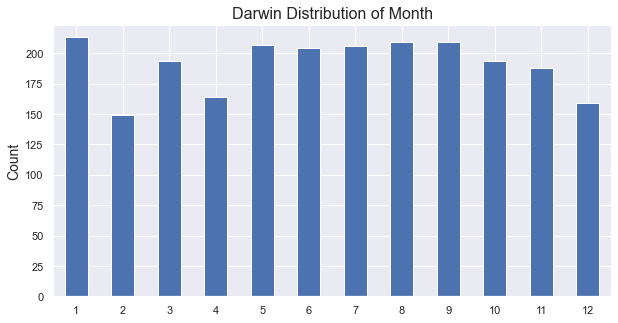

In [29]:
plot_month(x_train_Darwin, 'Darwin')

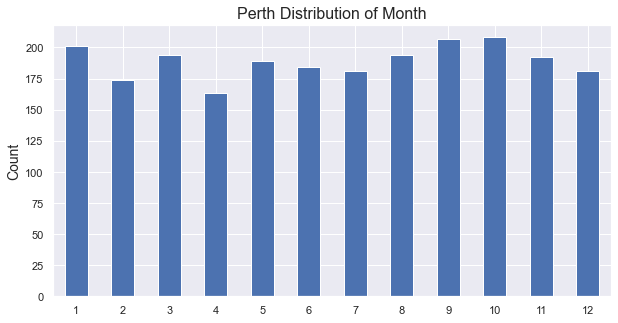

In [30]:
plot_month(x_train_Perth, 'Perth')

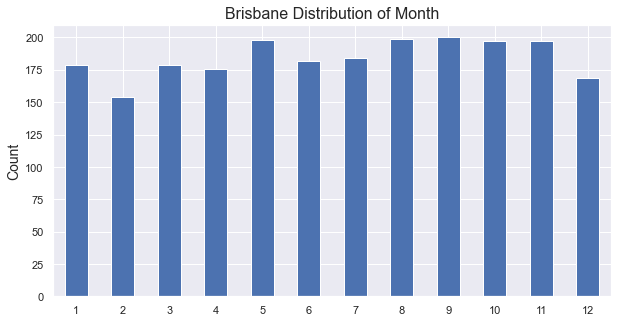

In [31]:
plot_month(x_train_Brisbane, 'Brisbane')

#### RainToday

In [32]:
def plot_raintoday(x_train, loc):
    # plot counts of variable
    x_train['RainToday'].value_counts().plot(kind='bar',figsize=(5,6))
    
    # add titles & axis labels
    plt.title(loc + ' Distribution of RainToday', size=16) 
    plt.ylabel('Count', size = 14)
    plt.xticks(rotation='horizontal')
    
    plt.show()

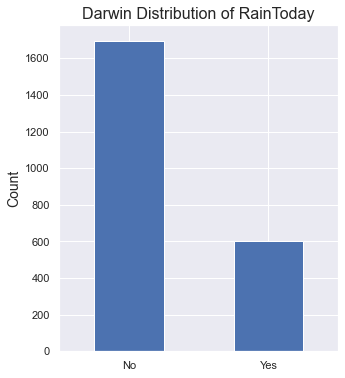

In [33]:
plot_raintoday(x_train_Darwin, 'Darwin')

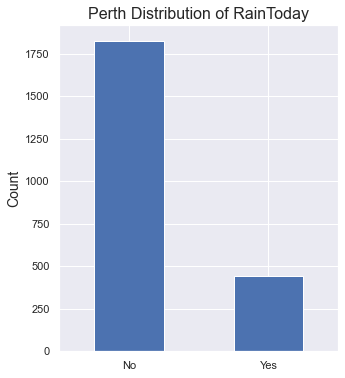

In [34]:
plot_raintoday(x_train_Perth, 'Perth')

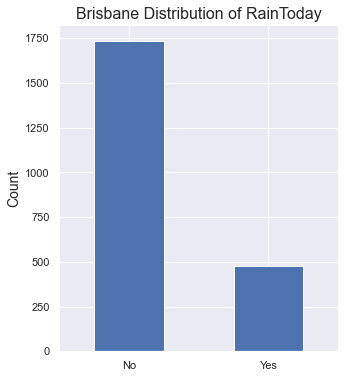

In [35]:
plot_raintoday(x_train_Brisbane, 'Brisbane')

#### WindGustDir

In [36]:
def plot_WindGustDir(x_train,loc):
    # plot counts of variable
    x_train['WindGustDir'].value_counts().plot(kind='bar',figsize=(15,6))
    
    # add titles & axis labels
    plt.title(loc + ' Distribution of WindGustDir', size=16) 
    plt.ylabel('Count', size = 14)
    
    # display plot
    plt.show()

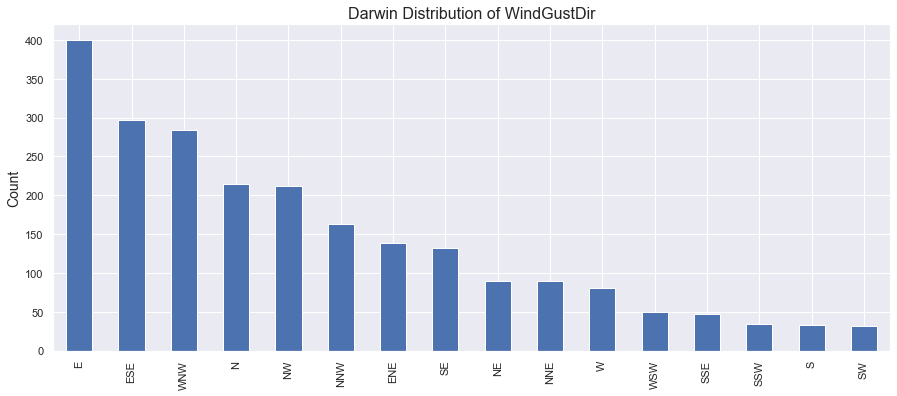

In [37]:
plot_WindGustDir(x_train_Darwin, 'Darwin')

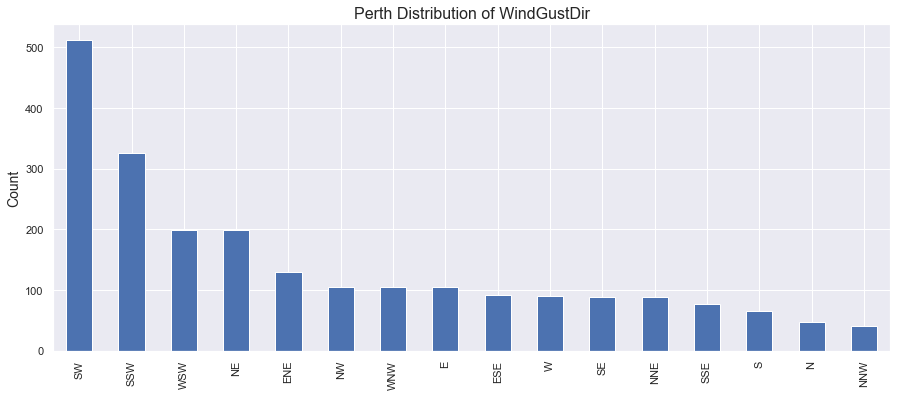

In [38]:
plot_WindGustDir(x_train_Perth, 'Perth')

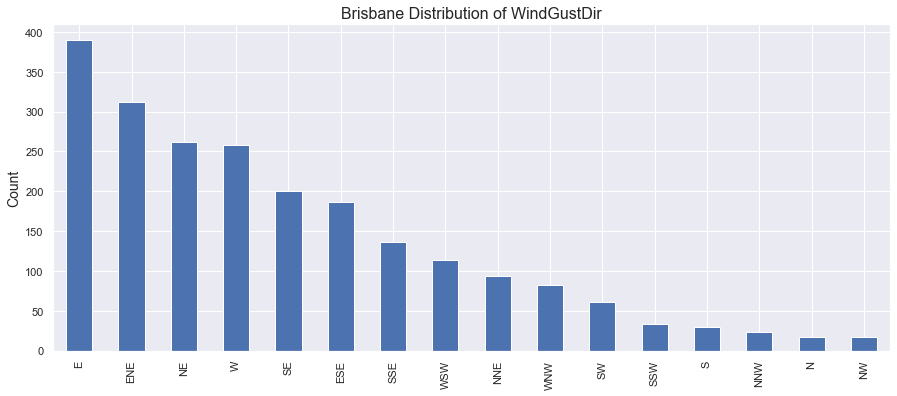

In [39]:
plot_WindGustDir(x_train_Brisbane, 'Brisbane')

#### WindDir9am

In [40]:
def plot_WindDir9am(x_train, loc):
    # plot counts of variable
    x_train['WindDir9am'].value_counts().plot(kind='bar', figsize=(15,6))
    
    # add titles & axis labels
    plt.title(loc + ' Distribution of WindDir9am', size=16) 
    plt.ylabel('Count', size = 14)
    
    #display plot
    plt.show()

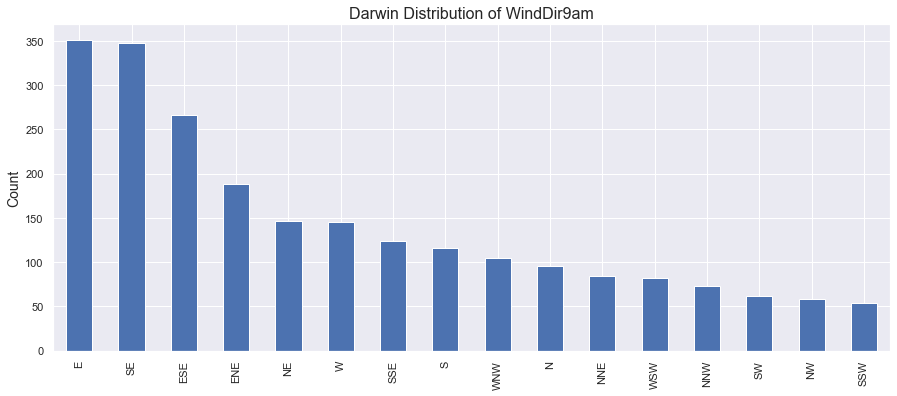

In [41]:
plot_WindDir9am(x_train_Darwin, 'Darwin')

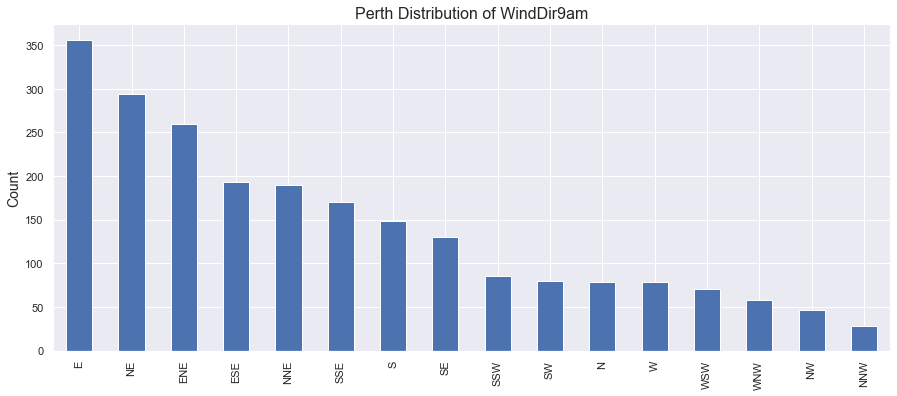

In [42]:
plot_WindDir9am(x_train_Perth, 'Perth')

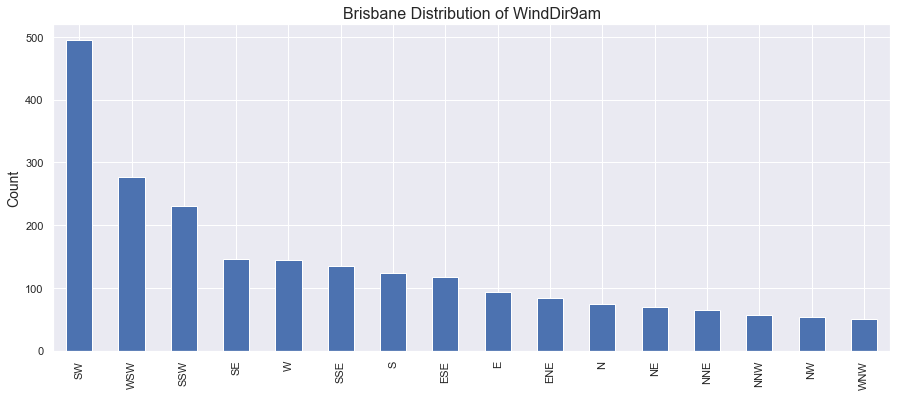

In [43]:
plot_WindDir9am(x_train_Brisbane, 'Brisbane')

#### WindDir3pm

In [44]:
def plot_WindDir3pm(x_train, loc):
    # plot counts of variable
    x_train['WindDir3pm'].value_counts().plot(kind='bar', figsize=(15,6))
    
    # add titles & axis labels
    plt.title(loc + ' Distribution of WindDir3pm', size=16) 
    plt.ylabel('Count', size = 14)
    
    # display plot
    plt.show()

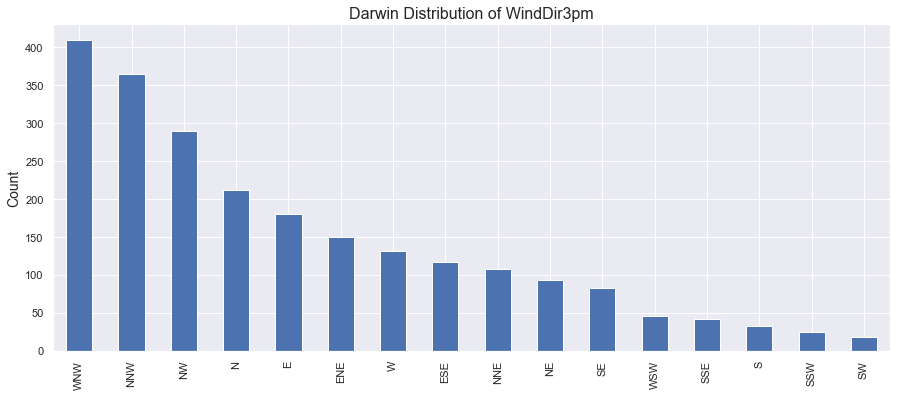

In [45]:
plot_WindDir3pm(x_train_Darwin, 'Darwin')

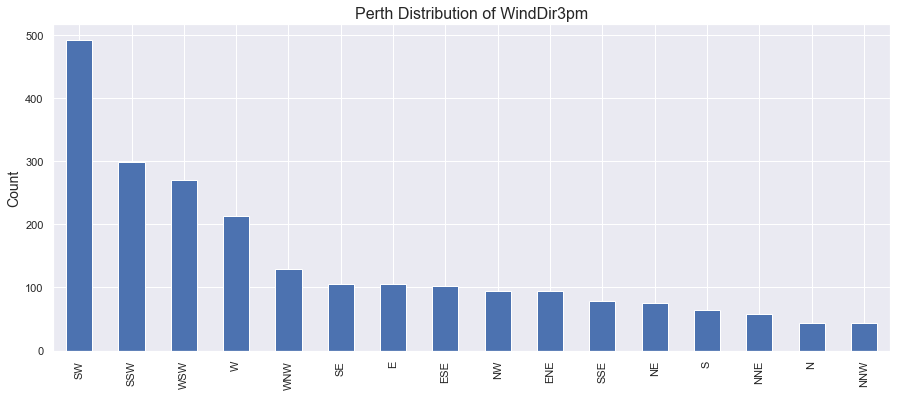

In [46]:
plot_WindDir3pm(x_train_Perth, 'Perth')

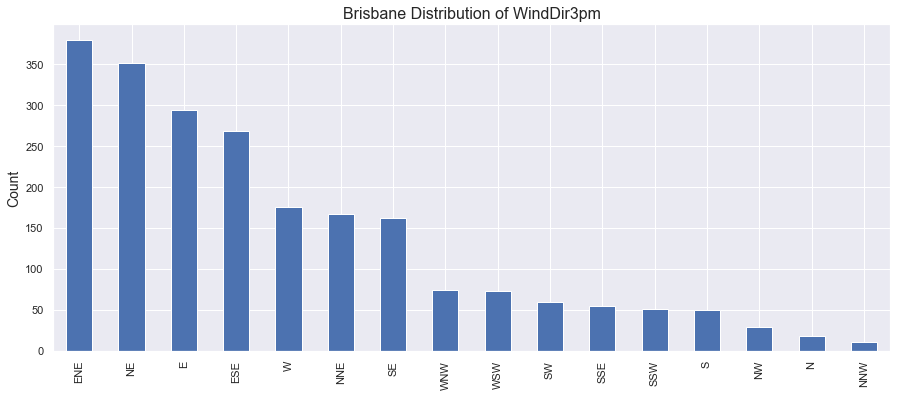

In [47]:
plot_WindDir3pm(x_train_Brisbane, 'Brisbane')

#### Rainfall

In [48]:
def plot_Rainfall(x_train, loc):
    # set figure size
    plt.figure(figsize=[15,5])
    
    # create strip plot
    sns.stripplot(x_train['Rainfall'])
    
    # add titles & axis labels
    plt.title(loc + ' Strip Plot of Rainfall', size=16) 
    plt.xlabel('Precipitation in Last 24 Hours (mm)', size = 14)
    
    # display plot
    plt.show()

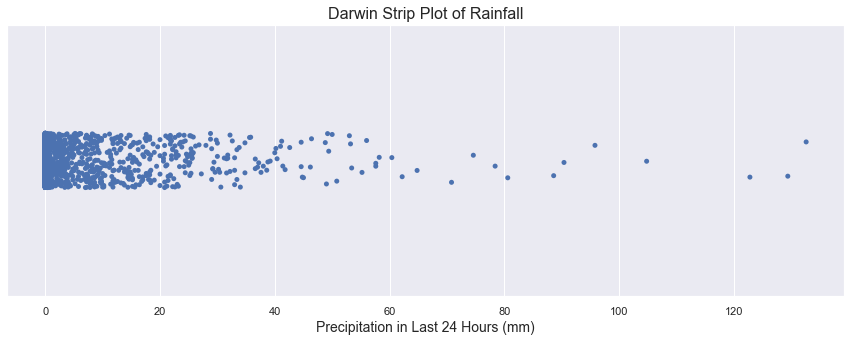

In [49]:
plot_Rainfall(x_train_Darwin, 'Darwin')

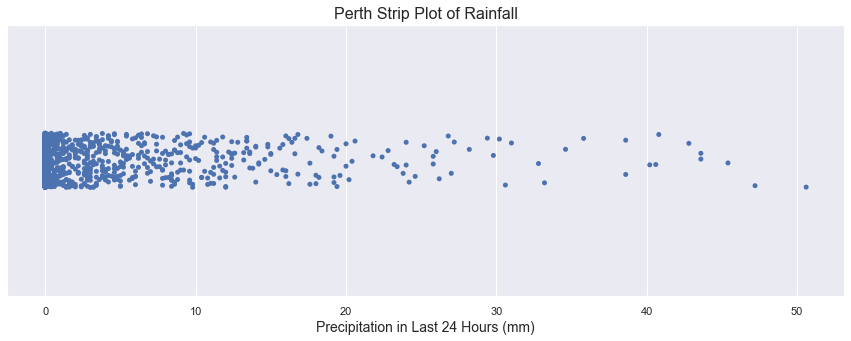

In [50]:
plot_Rainfall(x_train_Perth, 'Perth')

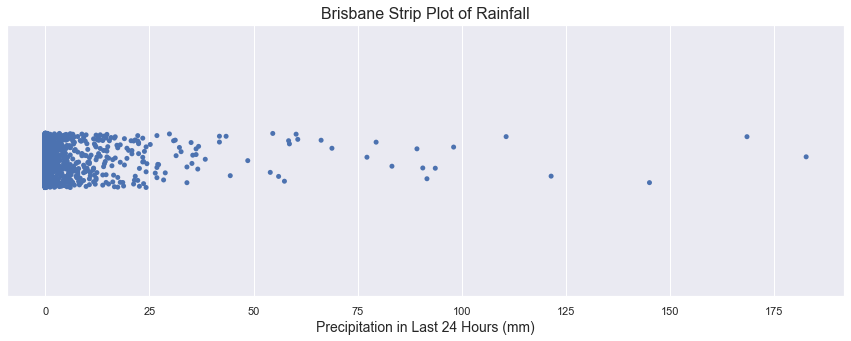

In [51]:
plot_Rainfall(x_train_Brisbane, 'Brisbane')

#### Evaporation

In [52]:
def plot_Evaporation(x_train, loc):
    # set figure size
    plt.figure(figsize=[15,5])
    
    # create strip plot
    sns.stripplot(x_train['Evaporation'])
    
    # add titles & axis labels
    plt.title(loc + ' Strip Plot of Evaporation', size=16) 
    plt.xlabel('Evaporation in Last 24 Hours (mm)', size = 14)
    
    # display plot
    plt.show()

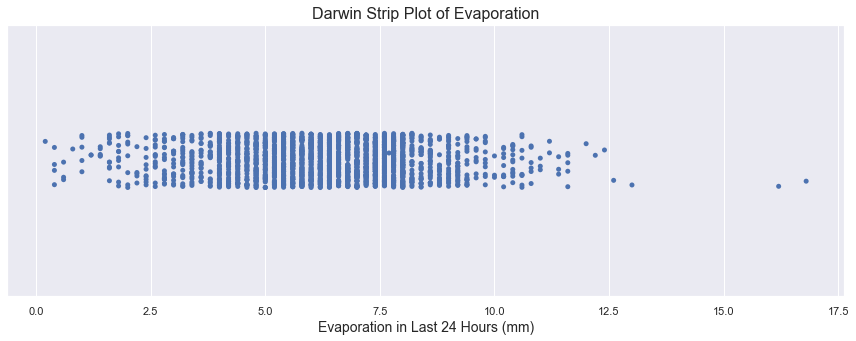

In [53]:
plot_Evaporation(x_train_Darwin, 'Darwin')

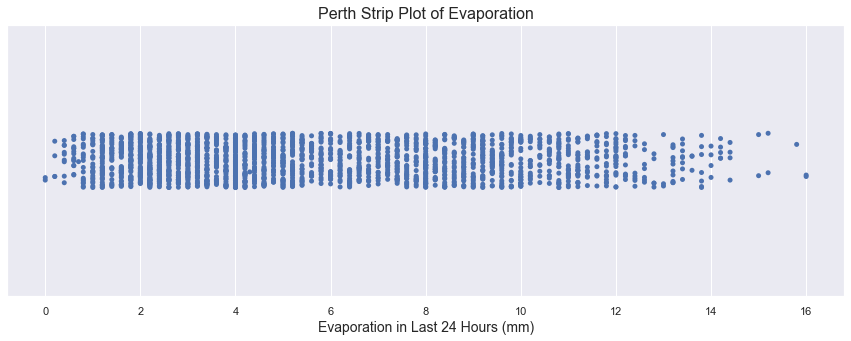

In [54]:
plot_Evaporation(x_train_Perth, 'Perth')

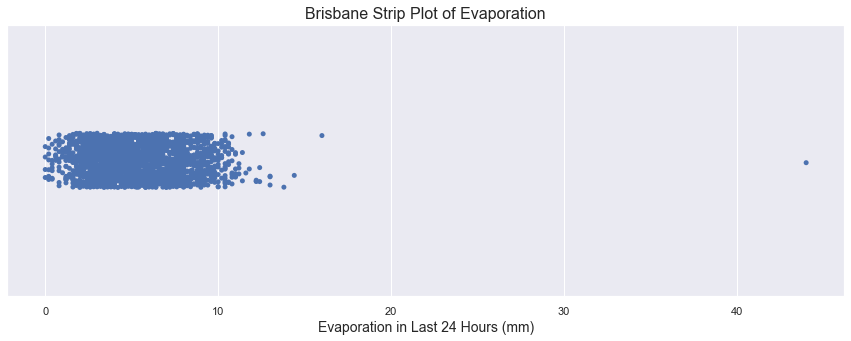

In [55]:
plot_Evaporation(x_train_Brisbane, 'Brisbane')

#### Sunshine

In [56]:
def plot_Sunshine(x_train, loc):
    # set figure size
    plt.figure(figsize=[15,5])
    
    # create histogram
    plt.hist(x_train['Sunshine'], bins=20)
    
    # add titles & axis labels
    plt.title(loc + ' Histogram of Sunshine', size=16) 
    plt.xlabel('Hours of Bright Sunshine in Last 24 Hours', size = 14)
    
    # display plot
    plt.show()

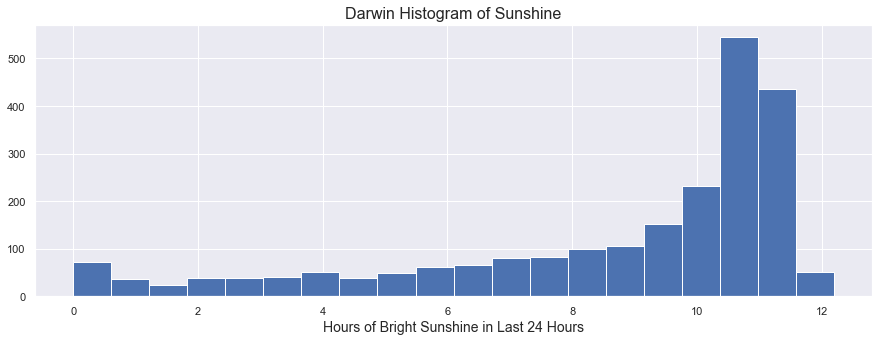

In [57]:
plot_Sunshine(x_train_Darwin, 'Darwin')

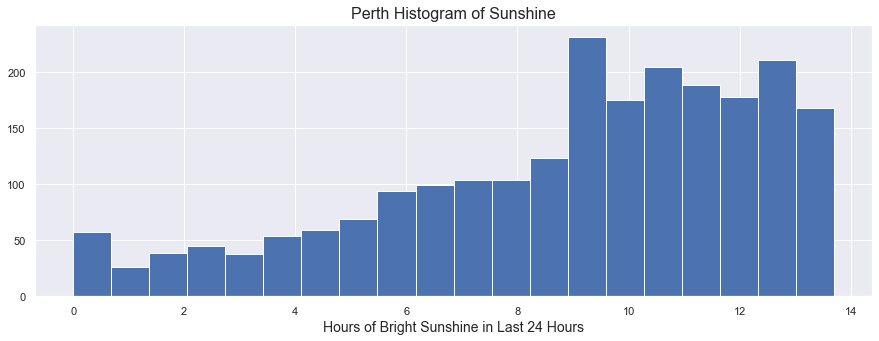

In [58]:
plot_Sunshine(x_train_Perth, 'Perth')

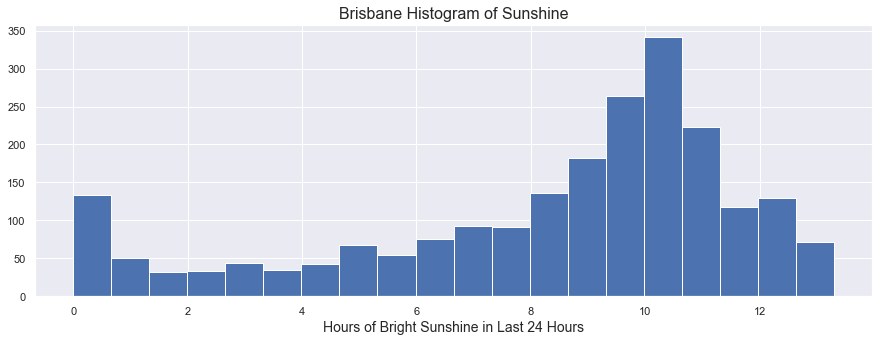

In [59]:
plot_Sunshine(x_train_Brisbane, 'Brisbane')

#### Temperature Variables

In [60]:
def plot_temp(x_train, loc):
    # set figure size
    plt.figure(figsize=[12,10])
    
    # plot on same axis
    plt.boxplot([x_train['MinTemp'], x_train['MaxTemp'], x_train['Temp9am'], x_train['Temp3pm']])
    
    # add titles & axis labels
    plt.title(loc + ' Boxplot of Temperature Variables', size=16) 
    plt.ylabel('Temperature in Degress Celsius', size = 14)
    
    # update x tick labels
    ax = plt.gca() 
    ax.set_xticklabels(['MinTemp','MaxTemp','Temp9am','Temp3pm'], size = 14) 
    
    # display plot
    plt.show()

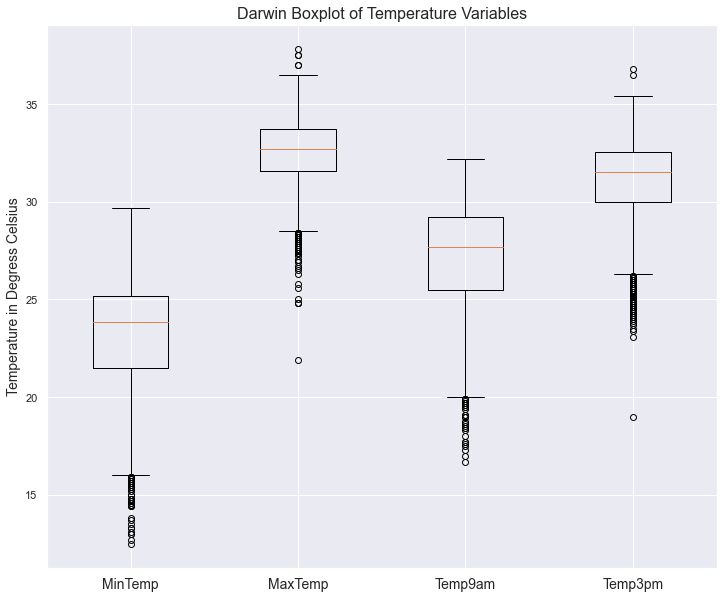

In [61]:
plot_temp(x_train_Darwin, 'Darwin')

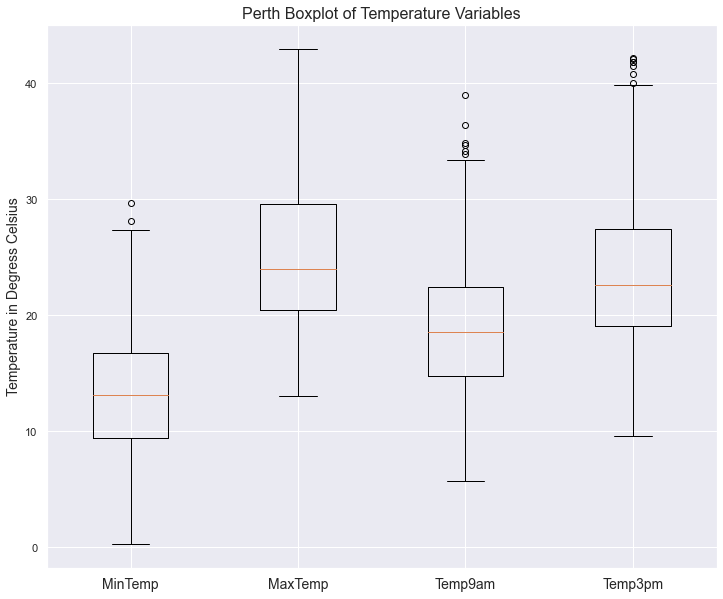

In [62]:
plot_temp(x_train_Perth, 'Perth')

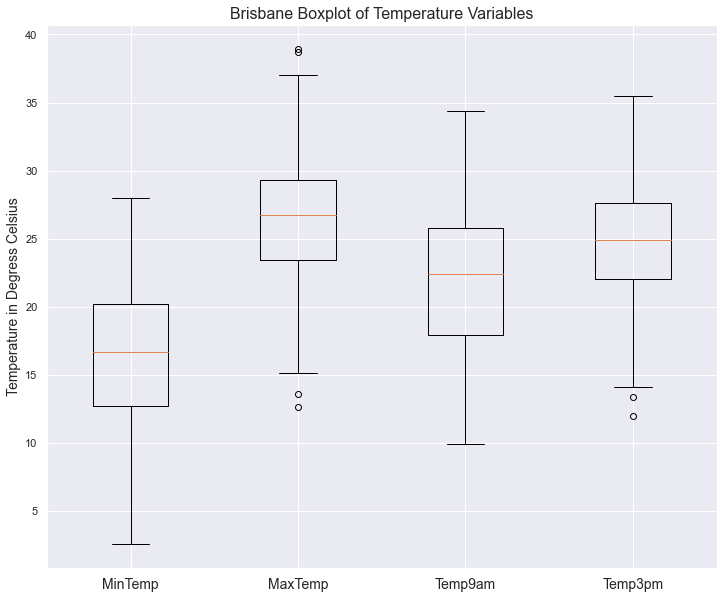

In [63]:
plot_temp(x_train_Brisbane, 'Brisbane')

#### Wind Speed

In [64]:
def plot_windspeed(x_train, loc):
    # set figure size
    plt.figure(figsize=[12,10])
    
    # plot on same axis
    plt.boxplot([x_train['WindGustSpeed'], x_train['WindSpeed9am'], x_train['WindSpeed3pm']])
    
    # add titles & axis labels
    plt.title(loc + ' Boxplot of Wind Speed Variables', size=16) 
    plt.ylabel('Wind Speed (kilometres per hour)', size = 14)
    
    # update x tick labels
    ax = plt.gca() 
    ax.set_xticklabels(['WindGustSpeed','WindSpeed9am','WindSpeed3pm'], size = 14) 
    
    # display plot
    plt.show()

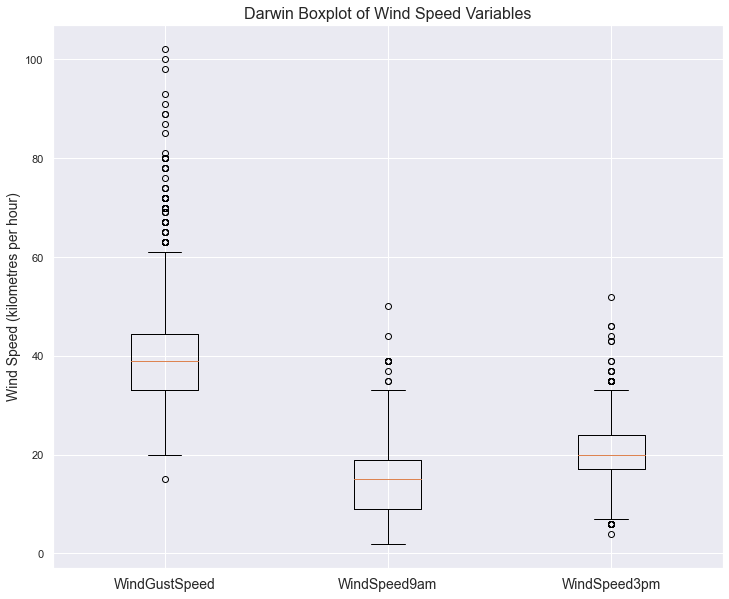

In [65]:
plot_windspeed(x_train_Darwin, 'Darwin')

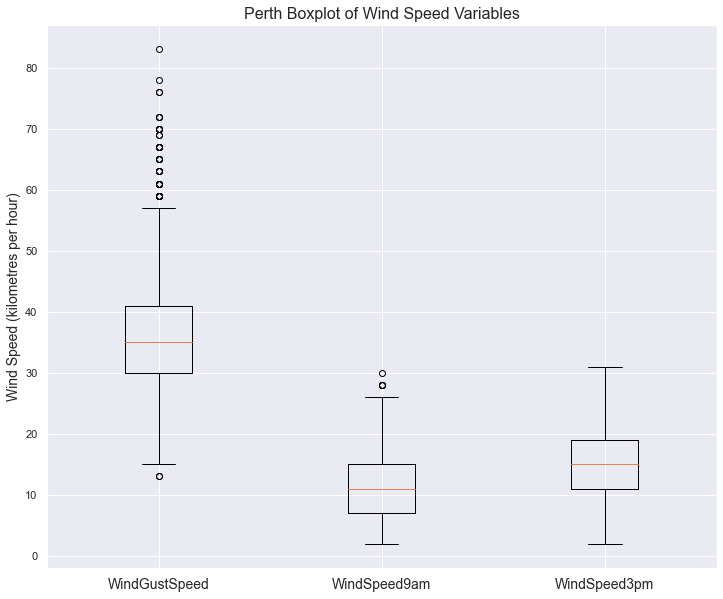

In [66]:
plot_windspeed(x_train_Perth, 'Perth')

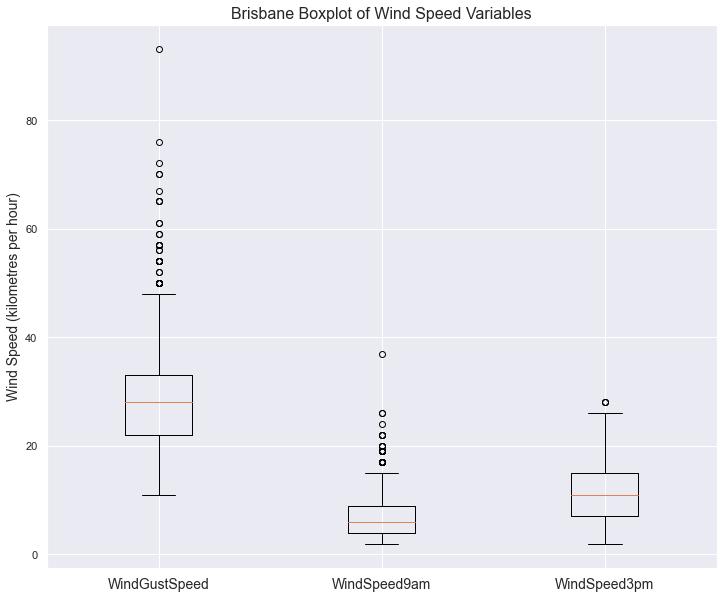

In [67]:
plot_windspeed(x_train_Brisbane, 'Brisbane')

#### Humidity

In [68]:
def plot_humidity(x_train, loc):
    # set figure size
    plt.figure(figsize=[9,9])
    
    # plot on same axis
    plt.boxplot([x_train['Humidity9am'], x_train['Humidity3pm']])
    
    # add titles & axis labels
    plt.title(loc + 'Boxplot of Humidity Variables', size=16) 
    plt.ylabel('Relative Humidity (%)', size = 14)
    
    # update x tick labels
    ax = plt.gca() 
    ax.set_xticklabels(['Humidity9am','Humidity3pm'], size = 14) 
    
    # display plot
    plt.show()

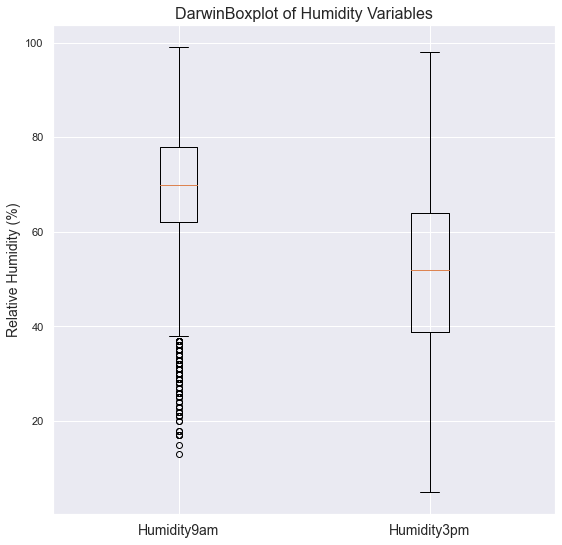

In [69]:
plot_humidity(x_train_Darwin, 'Darwin')

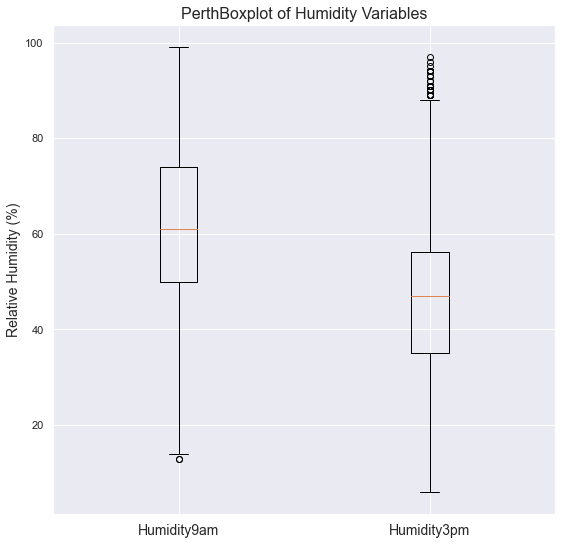

In [70]:
plot_humidity(x_train_Perth, 'Perth')

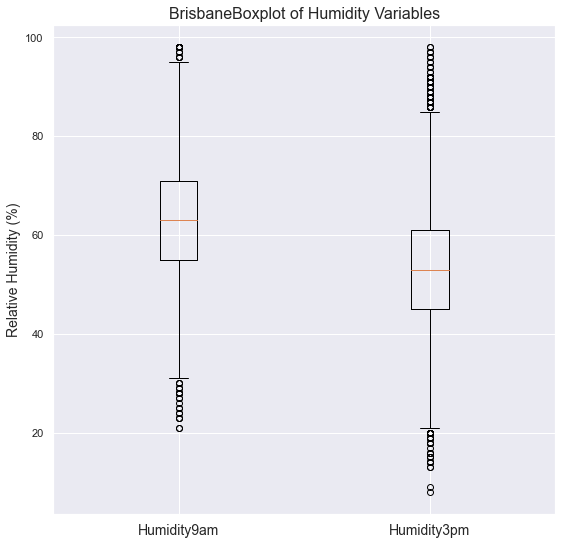

In [71]:
plot_humidity(x_train_Brisbane, 'Brisbane')

#### Pressure

In [72]:
def plot_pressure(x_train, loc):
    # set figure size
    plt.figure(figsize=[9,9])
    
    # plot on same axis
    plt.boxplot([x_train['Pressure9am'], x_train['Pressure3pm']])
    
    # add titles & axis labels
    plt.title(loc + ' Boxplot of Pressure Variables', size=16) 
    plt.ylabel('Atmospheric Pressure (hectopascals)', size = 14)
    
    # update x tick labels
    ax = plt.gca() 
    ax.set_xticklabels(['Pressure9am','Pressure3pm'], size = 14) 
    
    # display plot
    plt.show()

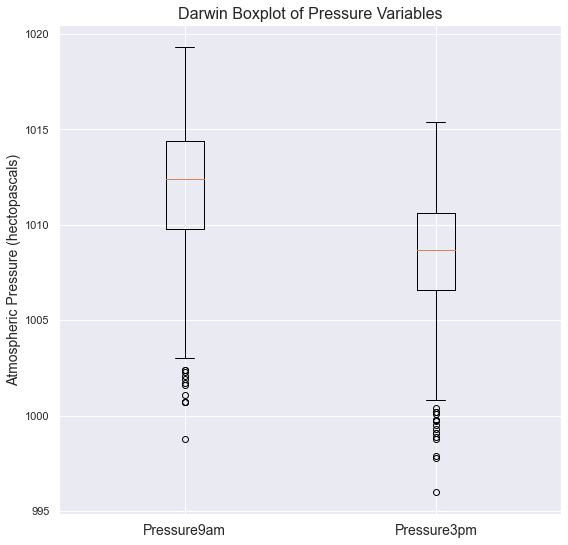

In [73]:
plot_pressure(x_train_Darwin, 'Darwin')

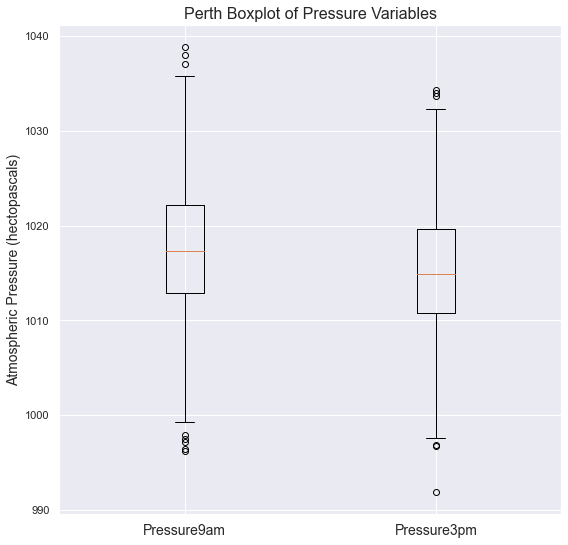

In [74]:
plot_pressure(x_train_Perth, 'Perth')

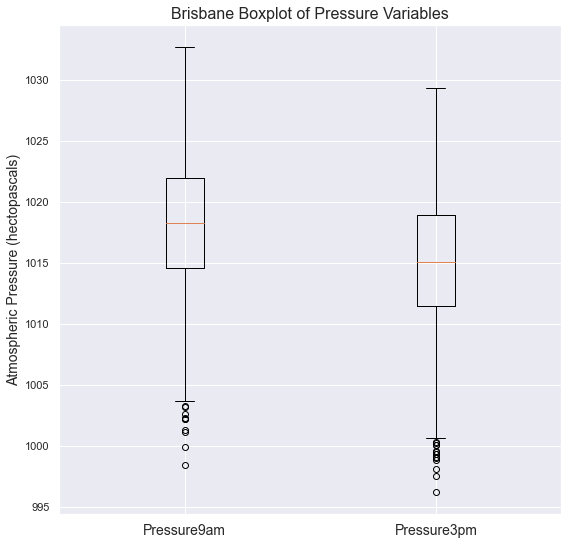

In [75]:
plot_pressure(x_train_Brisbane, 'Brisbane')

#### Clouds

In [76]:
def plot_clouds(x_train, loc):
    # set figure size
    plt.figure(figsize=[9,9])
    
    # plot on same axis
    plt.boxplot([x_train['Cloud9am'], x_train['Cloud3pm']])
    
    # add titles & axis labels
    plt.title(loc + ' Boxplot of Cloud Variables', size=16) 
    plt.ylabel('Fraction of Sky Obscured by Cloud', size = 14)
    
    # update x tick labels
    ax = plt.gca() 
    ax.set_xticklabels(['Cloud9am','Cloud3pm'], size = 14) 
    
    # display plot
    plt.show()

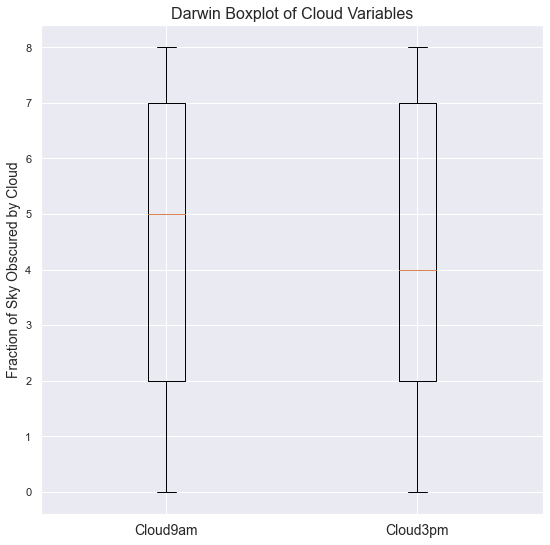

In [77]:
plot_clouds(x_train_Darwin, 'Darwin')

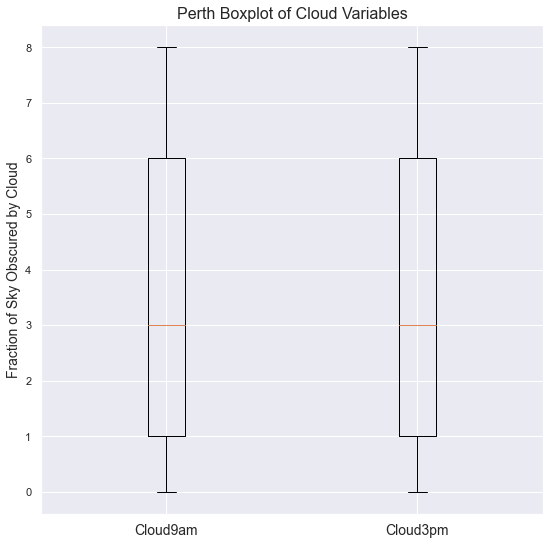

In [78]:
plot_clouds(x_train_Perth, 'Perth')

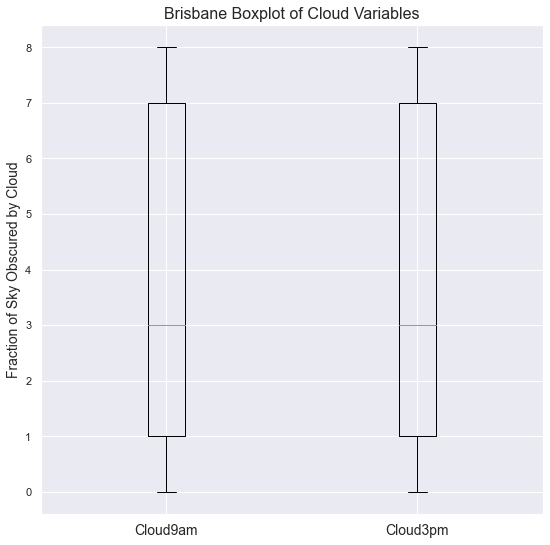

In [79]:
plot_clouds(x_train_Brisbane, 'Brisbane')

### Multivariate Graph Analysis

#### Pair Plots

In [80]:
def pairplot_temps(x_train):
    # create pair plot
    sns.pairplot(x_train, kind="scatter", vars=['MinTemp','MaxTemp','Temp9am','Temp3pm'])
    
    # display plot
    plt.show()

Pair Plot of Darwin Temperature Variables:


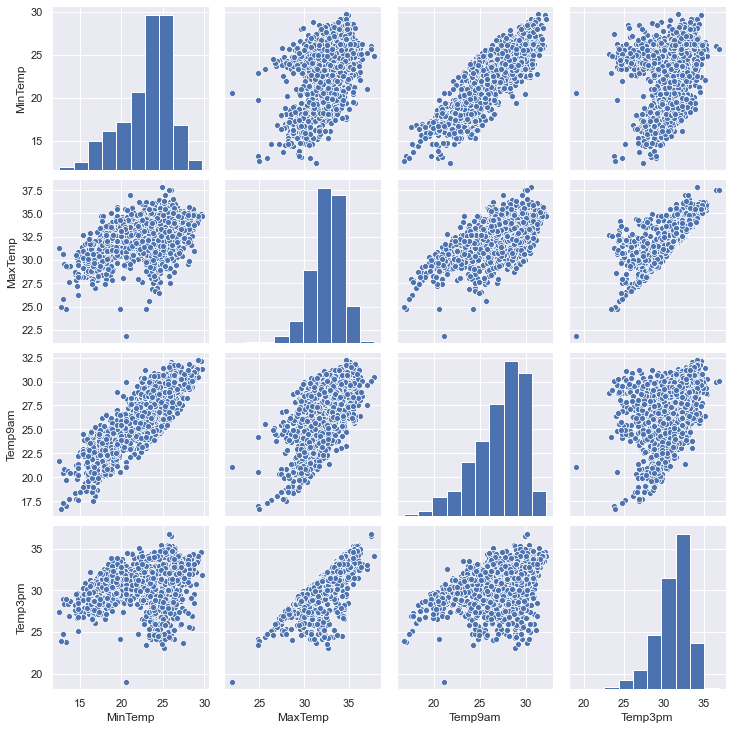

In [81]:
print("Pair Plot of Darwin Temperature Variables:")
pairplot_temps(x_train_Darwin)

Pair Plot of Perth Temperature Variables:


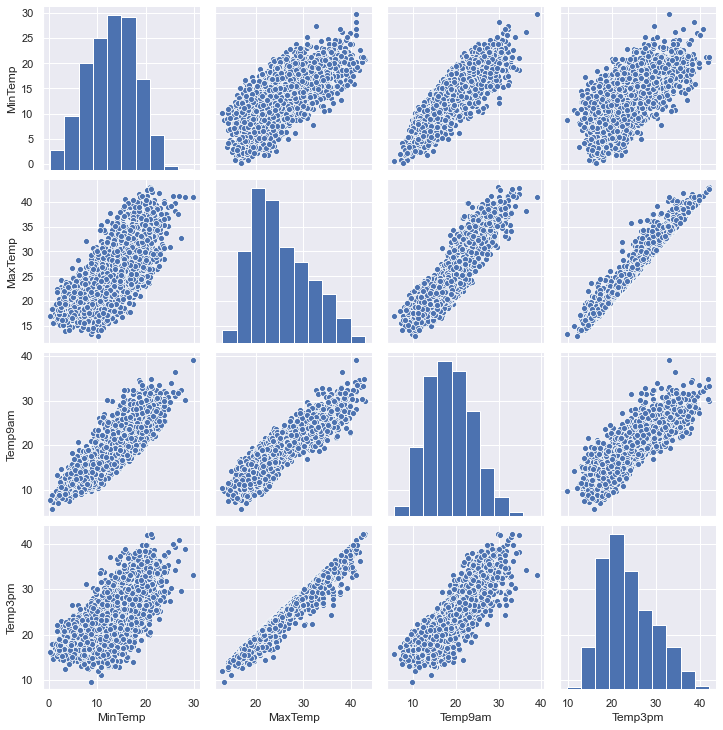

In [82]:
print("Pair Plot of Perth Temperature Variables:")
pairplot_temps(x_train_Perth)

Pair Plot of Brisbane Temperature Variables:


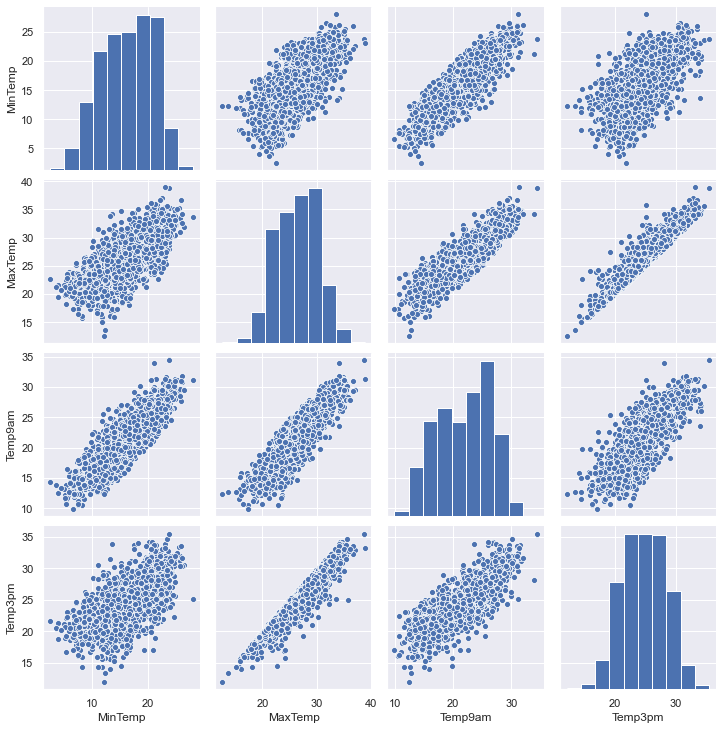

In [83]:
print("Pair Plot of Brisbane Temperature Variables:")
pairplot_temps(x_train_Brisbane)

In [84]:
def pairplot_rain(x_train):
    # create pair plot
    sns.pairplot(x_train, kind="scatter", vars=['Rainfall','Evaporation','Sunshine'])
    
    # display plot
    plt.show()

Pair Plot of Darwin Rain-Related Variables:


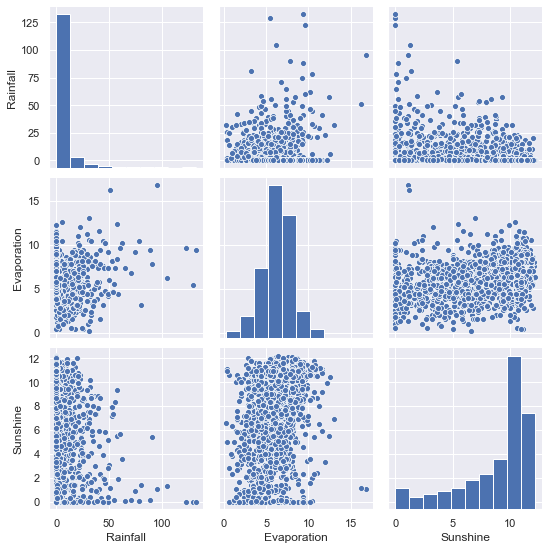

In [85]:
print("Pair Plot of Darwin Rain-Related Variables:")
pairplot_rain(x_train_Darwin)

Pair Plot of Perth Rain-Related Variables:


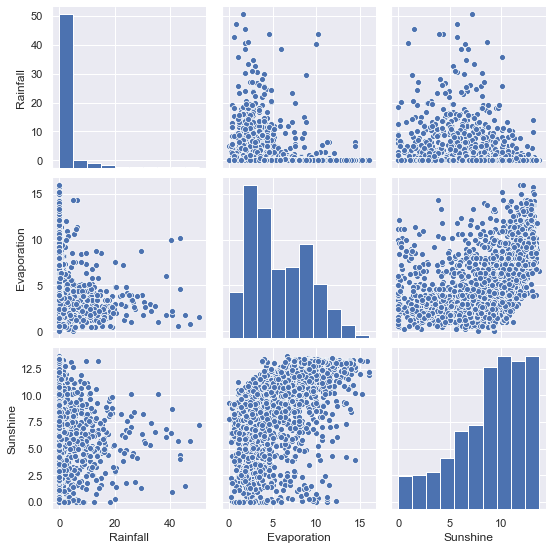

In [86]:
print("Pair Plot of Perth Rain-Related Variables:")
pairplot_rain(x_train_Perth)

Pair Plot of Brisbane Rain-Related Variables:


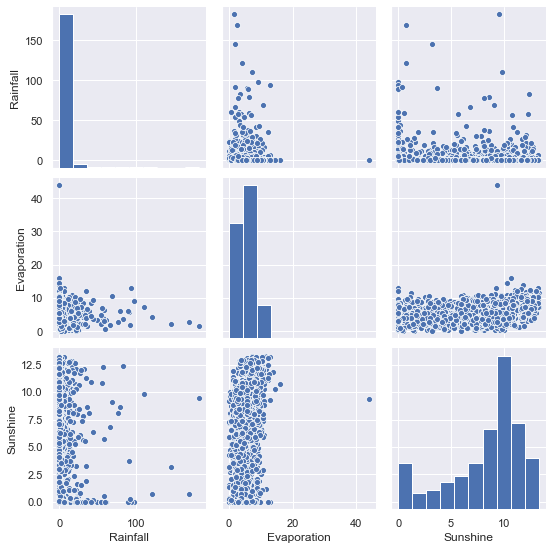

In [87]:
print("Pair Plot of Brisbane Rain-Related Variables:")
pairplot_rain(x_train_Brisbane)

In [88]:
def pairplot_wind(x_train):
    # create pair plot
    sns.pairplot(x_train, kind="scatter", vars=['WindGustSpeed','WindSpeed9am','WindSpeed3pm'])
    
    # display plot
    plt.show()

Pair Plot of Darwin Wind-Related Variables:


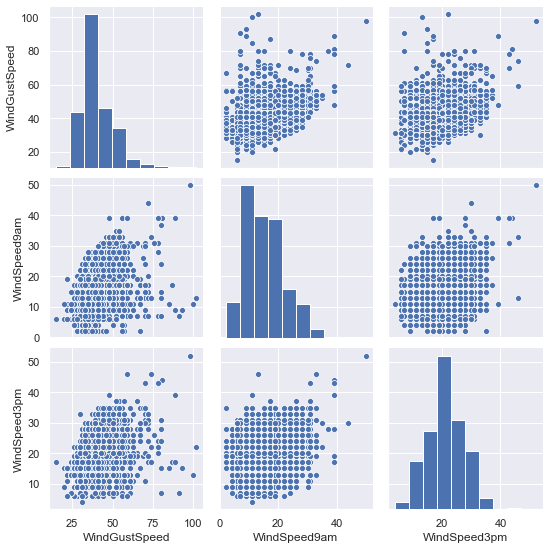

In [89]:
print("Pair Plot of Darwin Wind-Related Variables:")
pairplot_wind(x_train_Darwin)

Pair Plot of Perth Wind-Related Variables:


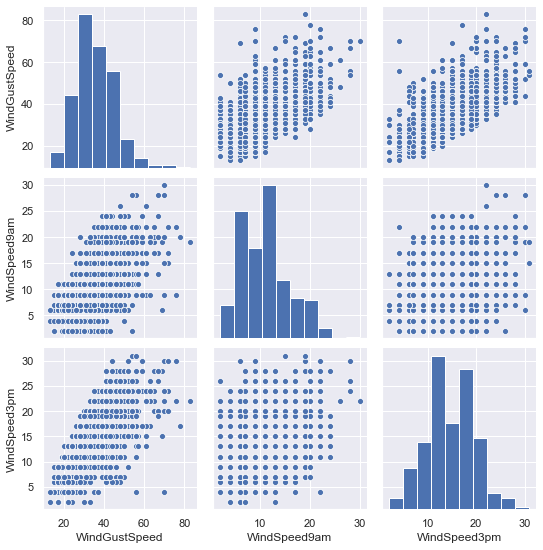

In [90]:
print("Pair Plot of Perth Wind-Related Variables:")
pairplot_wind(x_train_Perth)

Pair Plot of Brisbane Wind-Related Variables:


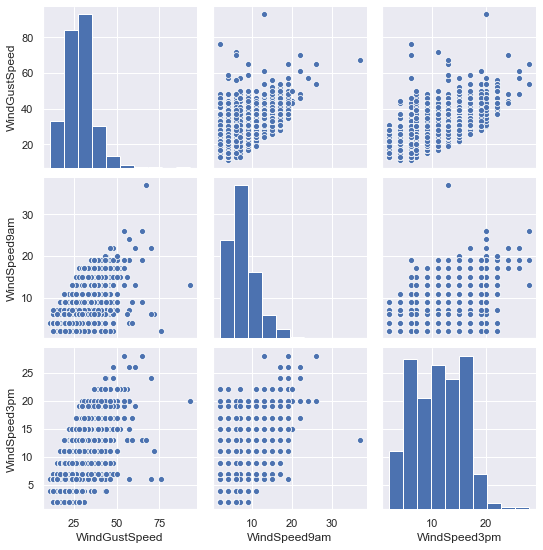

In [91]:
print("Pair Plot of Brisbane Wind-Related Variables:")
pairplot_wind(x_train_Brisbane)

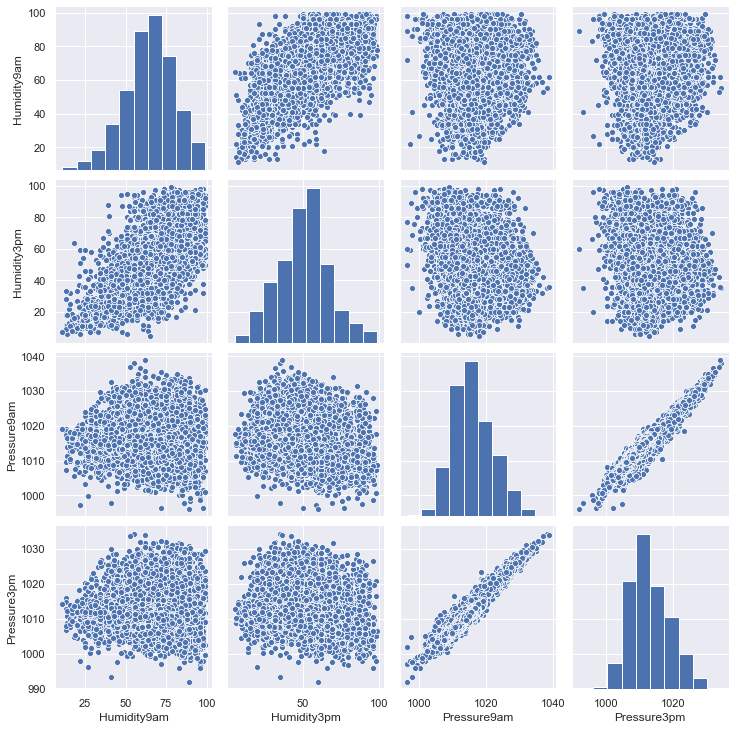

In [92]:
# create pair plot
sns.pairplot(df, kind="scatter", vars=['Humidity9am','Humidity3pm','Pressure9am','Pressure3pm'])
plt.show()

### Encode Features

#### RainToday

In [93]:
def encode_RainToday(x_train, x_test, loc):
    # change the target feature to binary values
    encode_cols = {"RainToday": {"Yes": 1, "No": 0}}
    
    # replace yes/no with 1/0 in train & test data
    x_train = x_train.replace(encode_cols)
    x_test = x_test.replace(encode_cols)
    
    # print the new distribution of RainToday
    print("New Distribution of RainToday for", loc, ":")
    print(x_train.RainToday.value_counts())
    
    return x_train, x_test

In [94]:
x_train_Darwin, x_test_Darwin = encode_RainToday(x_train_Darwin, x_test_Darwin, "Darwin")

New Distribution of RainToday for Darwin :
0    1696
1     600
Name: RainToday, dtype: int64


In [95]:
x_train_Perth, x_test_Perth = encode_RainToday(x_train_Perth, x_test_Perth, "Perth")

New Distribution of RainToday for Perth :
0    1827
1     441
Name: RainToday, dtype: int64


In [96]:
x_train_Brisbane, x_test_Brisbane = encode_RainToday(x_train_Brisbane, x_test_Brisbane, "Brisbane")

New Distribution of RainToday for Brisbane :
0    1737
1     477
Name: RainToday, dtype: int64


#### WindGustDir

In [97]:
def encode_WindGustDir(x_train, x_test, loc):
    # encode data in test & train data sets
    WindGustDir_train = pd.get_dummies(x_train.WindGustDir, prefix='WindGustDir')
    WindGustDir_test = pd.get_dummies(x_test.WindGustDir, prefix='WindGustDir')
    
    # add encoded data to data frame
    x_train = pd.concat([x_train, WindGustDir_train], axis=1)
    x_test = pd.concat([x_test, WindGustDir_test], axis=1)
    
    # Drop Original Column
    del x_train['WindGustDir']
    del x_test['WindGustDir']
    
    return x_train, x_test

In [98]:
x_train_Darwin, x_test_Darwin = encode_WindGustDir(x_train_Darwin, x_test_Darwin, "Darwin")

In [99]:
x_train_Perth, x_test_Perth = encode_WindGustDir(x_train_Perth, x_test_Perth, "Perth")

In [100]:
x_train_Brisbane, x_test_Brisbane = encode_WindGustDir(x_train_Brisbane, x_test_Brisbane, "Brisbane")

#### WindDir9am

In [101]:
def encode_WindDir9am(x_train, x_test, loc):
    # encode data
    WindDir9am_train = pd.get_dummies(x_train.WindDir9am, prefix='WindDir9am')
    WindDir9am_test = pd.get_dummies(x_test.WindDir9am, prefix='WindDir9am')
    
    # add encoded data to data frame
    x_train = pd.concat([x_train, WindDir9am_train], axis=1)
    x_test = pd.concat([x_test, WindDir9am_test], axis=1)
    
    # Drop Original Column
    del x_train['WindDir9am']
    del x_test['WindDir9am']
    
    return x_train,x_test

In [102]:
x_train_Darwin, x_test_Darwin = encode_WindDir9am(x_train_Darwin, x_test_Darwin, "Darwin")

In [103]:
x_train_Perth, x_test_Perth = encode_WindDir9am(x_train_Perth, x_test_Perth, "Perth")

In [104]:
x_train_Brisbane, x_test_Brisbane = encode_WindDir9am(x_train_Brisbane, x_test_Brisbane, "Brisbane")

#### WindDir3pm

In [105]:
def encode_WindDir3pm(x_train, x_test, loc):
    # encode data
    WindDir3pm_train = pd.get_dummies(x_train.WindDir3pm, prefix='WindDir3pm')
    WindDir3pm_test = pd.get_dummies(x_test.WindDir3pm, prefix='WindDir3pm')
    
    # add encoded data to data frame
    x_train = pd.concat([x_train, WindDir3pm_train], axis=1)
    x_test = pd.concat([x_test, WindDir3pm_test], axis=1)
    
    # Drop Original Column
    del x_train['WindDir3pm']
    del x_test['WindDir3pm']
    
    return x_train,x_test

In [106]:
x_train_Darwin, x_test_Darwin = encode_WindDir3pm(x_train_Darwin, x_test_Darwin, "Darwin")

In [107]:
x_train_Perth, x_test_Perth = encode_WindDir3pm(x_train_Perth, x_test_Perth, "Perth")

In [108]:
x_train_Brisbane, x_test_Brisbane = encode_WindDir3pm(x_train_Brisbane, x_test_Brisbane, "Brisbane")

In [109]:
print("Final structure for Darwin Dataframe:")
x_train_Darwin.info(verbose=True)

Final structure for Darwin Dataframe:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2296 entries, 140784 to 141677
Data columns (total 66 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MinTemp          2296 non-null   float64
 1   MaxTemp          2296 non-null   float64
 2   Rainfall         2296 non-null   float64
 3   Evaporation      2296 non-null   float64
 4   Sunshine         2296 non-null   float64
 5   WindGustSpeed    2296 non-null   float64
 6   WindSpeed9am     2296 non-null   float64
 7   WindSpeed3pm     2296 non-null   float64
 8   Humidity9am      2296 non-null   float64
 9   Humidity3pm      2296 non-null   float64
 10  Pressure9am      2296 non-null   float64
 11  Pressure3pm      2296 non-null   float64
 12  Cloud9am         2296 non-null   float64
 13  Cloud3pm         2296 non-null   float64
 14  Temp9am          2296 non-null   float64
 15  Temp3pm          2296 non-null   float64
 16  RainToday      

In [110]:
print("Final structure for Perth Dataframe:")
x_train_Perth.info(verbose=True)

Final structure for Perth Dataframe:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2268 entries, 123616 to 121171
Data columns (total 66 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MinTemp          2268 non-null   float64
 1   MaxTemp          2268 non-null   float64
 2   Rainfall         2268 non-null   float64
 3   Evaporation      2268 non-null   float64
 4   Sunshine         2268 non-null   float64
 5   WindGustSpeed    2268 non-null   float64
 6   WindSpeed9am     2268 non-null   float64
 7   WindSpeed3pm     2268 non-null   float64
 8   Humidity9am      2268 non-null   float64
 9   Humidity3pm      2268 non-null   float64
 10  Pressure9am      2268 non-null   float64
 11  Pressure3pm      2268 non-null   float64
 12  Cloud9am         2268 non-null   float64
 13  Cloud3pm         2268 non-null   float64
 14  Temp9am          2268 non-null   float64
 15  Temp3pm          2268 non-null   float64
 16  RainToday       

In [111]:
print("Final structure for Brisbane Dataframe:")
x_train_Brisbane.info(verbose=True)

Final structure for Brisbane Dataframe:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2214 entries, 84596 to 85209
Data columns (total 66 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MinTemp          2214 non-null   float64
 1   MaxTemp          2214 non-null   float64
 2   Rainfall         2214 non-null   float64
 3   Evaporation      2214 non-null   float64
 4   Sunshine         2214 non-null   float64
 5   WindGustSpeed    2214 non-null   float64
 6   WindSpeed9am     2214 non-null   float64
 7   WindSpeed3pm     2214 non-null   float64
 8   Humidity9am      2214 non-null   float64
 9   Humidity3pm      2214 non-null   float64
 10  Pressure9am      2214 non-null   float64
 11  Pressure3pm      2214 non-null   float64
 12  Cloud9am         2214 non-null   float64
 13  Cloud3pm         2214 non-null   float64
 14  Temp9am          2214 non-null   float64
 15  Temp3pm          2214 non-null   float64
 16  RainToday      

### Feature Selection

#### Recursive Feature Elimination

In [112]:
# make an instance of RandomForest algorithm using seed for reproducibility
rfc = RandomForestClassifier(random_state=123)

In [113]:
#create an instance of RFECV using model instance
rfecv = RFECV(estimator=rfc, 
              step=1, #removes 1 feature per iteration
              cv=StratifiedKFold(10), 
              scoring='f1') #metric to optimize

#The F1 score can be interpreted as a weighted average of the precision and recall, where an 
#F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision 
#and recall to the F1 score are equal. 

In [114]:
def feature_selection(x_train, y_train, x_test, loc):
    #recursively eliminate features
    rfecv.fit(x_train, y_train)
    
    # set figure size
    plt.figure(figsize=(12, 7))
    
    # add title and axis labels
    plt.title(loc + ' Recursive Feature Elimination with Cross-Validation', fontsize=18)
    plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
    plt.ylabel('RFECV Grid Score', fontsize=14, labelpad=20)
    
    # create line plot of results
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    
    # change tick frequency
    plt.xticks(np.arange(0, 70, 5.0))
    
    # display plot
    plt.show()
    
    print(loc + ' Optimal number of features:', rfecv.n_features_,"\n")
    
    # get unimportant features to be dropped
    drop_features = x_train.columns[np.where(rfecv.support_ == False)[0]]
    
    print('Columns to be dropped:')
    print(drop_features,"\n")
    
    # drop unimportant features
    x_train.drop(drop_features, axis=1, inplace=True)
    x_test.drop(drop_features, axis=1, inplace=True)
    
    # initialize new data frame to store features & their importance value
    dset = pd.DataFrame()
    dset['attr'] = x_train.columns
    dset['importance'] = rfecv.estimator_.feature_importances_
    
    # sort by importance
    dset = dset.sort_values(by='importance', ascending=False)
    
    # set figure size
    plt.figure(figsize=(6, 12))
    
    # create bar plot
    plt.barh(y=dset['attr'], width=dset['importance'])
    
    # add title
    plt.title(loc +' RFECV - Feature Importances', fontsize=20)
    
    # add axis label
    plt.xlabel('Importance', fontsize=14, labelpad=20)
    
    # display plot
    plt.show() 

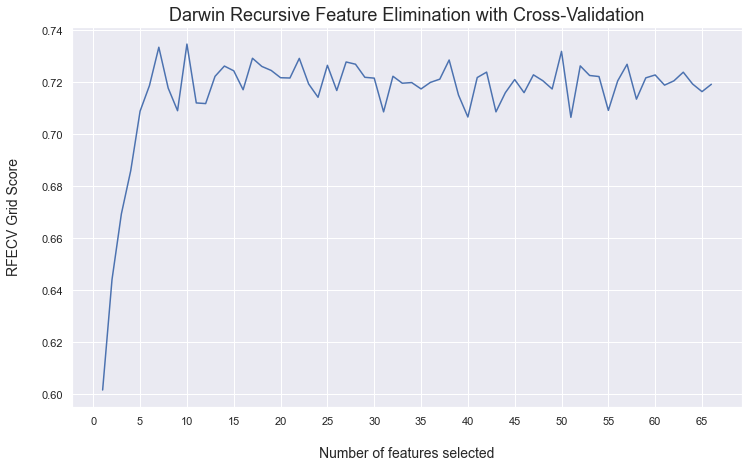

Darwin Optimal number of features: 10 

Columns to be dropped:
Index(['Evaporation', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Cloud9am', 'Cloud3pm', 'RainToday', 'Month', 'WindGustDir_E',
       'WindGustDir_ENE', 'WindGustDir_ESE', 'WindGustDir_N', 'WindGustDir_NE',
       'WindGustDir_NNE', 'WindGustDir_NNW', 'WindGustDir_NW', 'WindGustDir_S',
       'WindGustDir_SE', 'WindGustDir_SSE', 'WindGustDir_SSW',
       'WindGustDir_SW', 'WindGustDir_W', 'WindGustDir_WNW', 'WindGustDir_WSW',
       'WindDir9am_E', 'WindDir9am_ENE', 'WindDir9am_ESE', 'WindDir9am_N',
       'WindDir9am_NE', 'WindDir9am_NNE', 'WindDir9am_NNW', 'WindDir9am_NW',
       'WindDir9am_S', 'WindDir9am_SE', 'WindDir9am_SSE', 'WindDir9am_SSW',
       'WindDir9am_SW', 'WindDir9am_W', 'WindDir9am_WNW', 'WindDir9am_WSW',
       'WindDir3pm_E', 'WindDir3pm_ENE', 'WindDir3pm_ESE', 'WindDir3pm_N',
       'WindDir3pm_NE', 'WindDir3pm_NNE', 'WindDir3pm_NNW', 'WindDir3pm_NW',
       'WindDir3pm_S', 'WindDir3pm_SE',

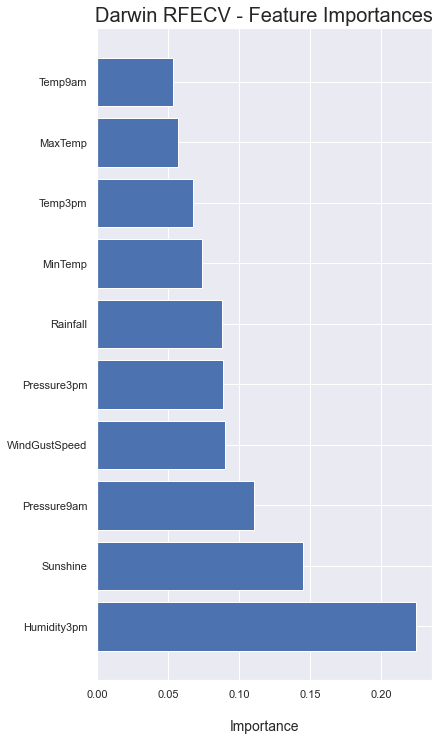

In [115]:
feature_selection(x_train_Darwin, y_train_Darwin, x_test_Darwin, "Darwin")

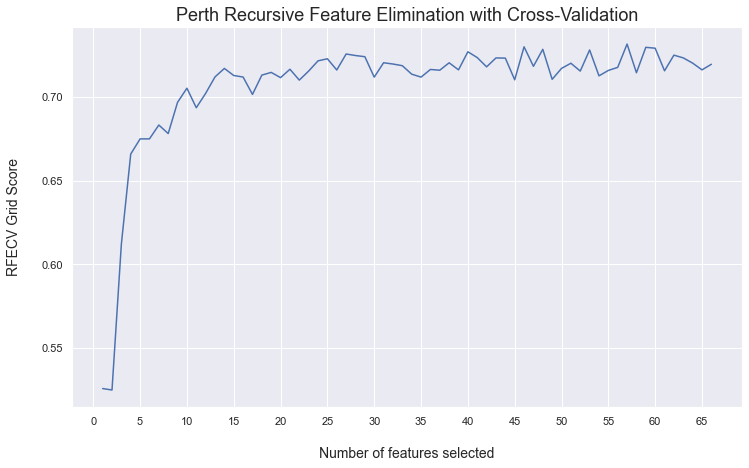

Perth Optimal number of features: 57 

Columns to be dropped:
Index(['WindGustDir_E', 'WindGustDir_ESE', 'WindGustDir_S', 'WindGustDir_SE',
       'WindDir9am_NNW', 'WindDir3pm_ENE', 'WindDir3pm_ESE', 'WindDir3pm_NE',
       'WindDir3pm_SE'],
      dtype='object') 



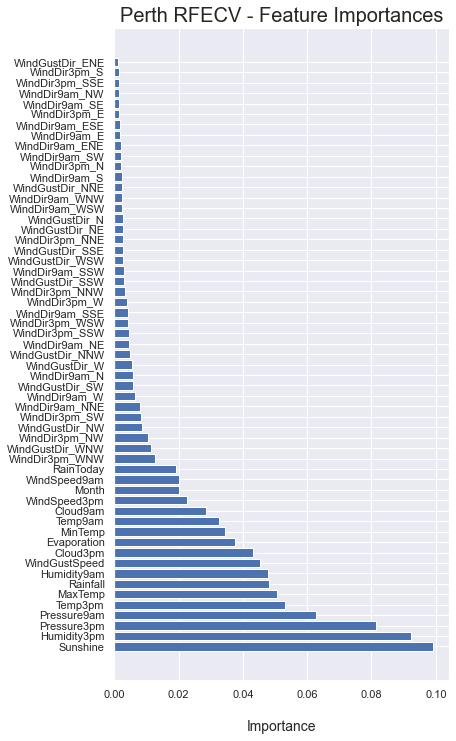

In [116]:
feature_selection(x_train_Perth, y_train_Perth, x_test_Perth, "Perth")

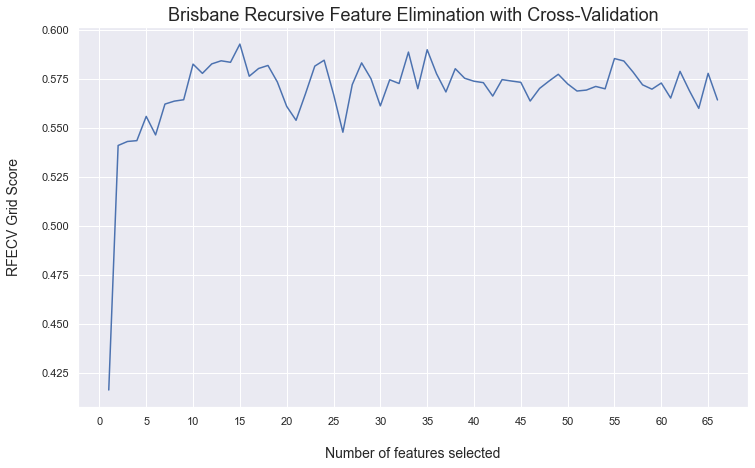

Brisbane Optimal number of features: 15 

Columns to be dropped:
Index(['WindSpeed9am', 'RainToday', 'Month', 'WindGustDir_E',
       'WindGustDir_ENE', 'WindGustDir_ESE', 'WindGustDir_N', 'WindGustDir_NE',
       'WindGustDir_NNE', 'WindGustDir_NNW', 'WindGustDir_NW', 'WindGustDir_S',
       'WindGustDir_SE', 'WindGustDir_SSE', 'WindGustDir_SSW',
       'WindGustDir_SW', 'WindGustDir_W', 'WindGustDir_WNW', 'WindGustDir_WSW',
       'WindDir9am_E', 'WindDir9am_ENE', 'WindDir9am_ESE', 'WindDir9am_N',
       'WindDir9am_NE', 'WindDir9am_NNE', 'WindDir9am_NNW', 'WindDir9am_NW',
       'WindDir9am_S', 'WindDir9am_SE', 'WindDir9am_SSE', 'WindDir9am_SSW',
       'WindDir9am_SW', 'WindDir9am_W', 'WindDir9am_WNW', 'WindDir9am_WSW',
       'WindDir3pm_E', 'WindDir3pm_ENE', 'WindDir3pm_ESE', 'WindDir3pm_N',
       'WindDir3pm_NE', 'WindDir3pm_NNE', 'WindDir3pm_NNW', 'WindDir3pm_NW',
       'WindDir3pm_S', 'WindDir3pm_SE', 'WindDir3pm_SSE', 'WindDir3pm_SSW',
       'WindDir3pm_SW', 'WindDir3pm_W'

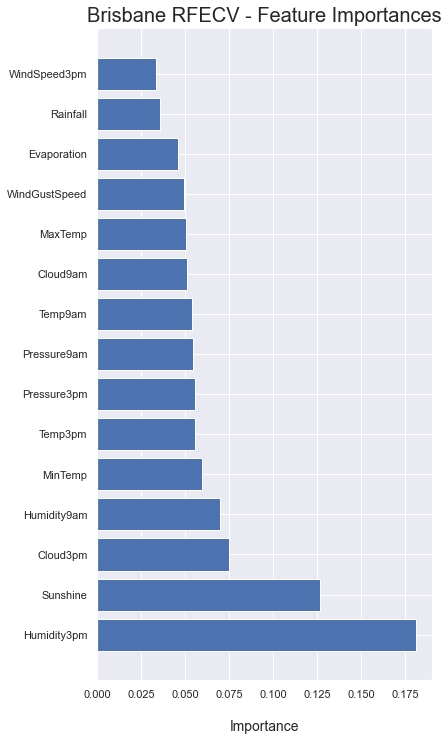

In [117]:
feature_selection(x_train_Brisbane, y_train_Brisbane, x_test_Brisbane, "Brisbane")

In [118]:
# observe new structure
x_train_Darwin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2296 entries, 140784 to 141677
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MinTemp        2296 non-null   float64
 1   MaxTemp        2296 non-null   float64
 2   Rainfall       2296 non-null   float64
 3   Sunshine       2296 non-null   float64
 4   WindGustSpeed  2296 non-null   float64
 5   Humidity3pm    2296 non-null   float64
 6   Pressure9am    2296 non-null   float64
 7   Pressure3pm    2296 non-null   float64
 8   Temp9am        2296 non-null   float64
 9   Temp3pm        2296 non-null   float64
dtypes: float64(10)
memory usage: 197.3 KB


In [119]:
# observe new structure
x_train_Perth.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2268 entries, 123616 to 121171
Data columns (total 57 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MinTemp          2268 non-null   float64
 1   MaxTemp          2268 non-null   float64
 2   Rainfall         2268 non-null   float64
 3   Evaporation      2268 non-null   float64
 4   Sunshine         2268 non-null   float64
 5   WindGustSpeed    2268 non-null   float64
 6   WindSpeed9am     2268 non-null   float64
 7   WindSpeed3pm     2268 non-null   float64
 8   Humidity9am      2268 non-null   float64
 9   Humidity3pm      2268 non-null   float64
 10  Pressure9am      2268 non-null   float64
 11  Pressure3pm      2268 non-null   float64
 12  Cloud9am         2268 non-null   float64
 13  Cloud3pm         2268 non-null   float64
 14  Temp9am          2268 non-null   float64
 15  Temp3pm          2268 non-null   float64
 16  RainToday        2268 non-null   int64  
 17  Month  

In [120]:
# observe new structure
x_train_Brisbane.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2214 entries, 84596 to 85209
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MinTemp        2214 non-null   float64
 1   MaxTemp        2214 non-null   float64
 2   Rainfall       2214 non-null   float64
 3   Evaporation    2214 non-null   float64
 4   Sunshine       2214 non-null   float64
 5   WindGustSpeed  2214 non-null   float64
 6   WindSpeed3pm   2214 non-null   float64
 7   Humidity9am    2214 non-null   float64
 8   Humidity3pm    2214 non-null   float64
 9   Pressure9am    2214 non-null   float64
 10  Pressure3pm    2214 non-null   float64
 11  Cloud9am       2214 non-null   float64
 12  Cloud3pm       2214 non-null   float64
 13  Temp9am        2214 non-null   float64
 14  Temp3pm        2214 non-null   float64
dtypes: float64(15)
memory usage: 276.8 KB


## Model Training

**Create Pipelines**

In [121]:
# logistic regression
pipe_lr = Pipeline([('selector', SelectKBest()),
                    ("classifier",LogisticRegression(class_weight='balanced', random_state=123, solver='liblinear'))])

# random forest
pipe_rf = Pipeline([('selector', SelectKBest()),
                    ("classifier",RandomForestClassifier(random_state=123))])

# naive bayes
pipe_nb = Pipeline([('selector', SelectKBest()),
                    ("classifier",GaussianNB())])

**Define Possible Values for Hyperparameters**

In [122]:
# logistic regression - Darwin
params_lr_Darwin = {"selector__k": [4, 6, 8],
          "classifier__C": [10**i for i in range (-3,3)],
          "classifier__penalty": ['l1', 'l2']}

# logistic regression - Perth
params_lr_Perth = {"selector__k": [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55],
          "classifier__C": [10**i for i in range (-3,3)],
          "classifier__penalty": ['l1', 'l2']}

# logistic regression - Brisbane
params_lr_Brisbane = {"selector__k": [4, 6, 8, 10, 12, 14],
          "classifier__C": [10**i for i in range (-3,3)],
          "classifier__penalty": ['l1', 'l2']}

# random forest
params_rf = {"selector__k": [4, 6, 8, 10],
             "classifier__n_estimators": [20, 50, 100, 300, 500, 1000],
             "classifier__class_weight": ['balanced',None],
             "classifier__max_depth": [2, 4, 6, 8],
             "classifier__max_features": ['sqrt','log2',None]}

# naive bayes
params_nb = {'classifier__var_smoothing': np.logspace(0,-9, num=100)}

**Create grid search with 5-fold cross-validation**

In [123]:
# logistic regression - Darwin
grid_lr_Darwin = GridSearchCV(pipe_lr, 
                       param_grid=params_lr_Darwin, 
                       n_jobs=-1, 
                       scoring='roc_auc')

# logistic regression - Perth
grid_lr_Perth = GridSearchCV(pipe_lr, 
                       param_grid=params_lr_Perth, 
                       n_jobs=-1, 
                       scoring='roc_auc')

# logistic regression - Brisbane
grid_lr_Brisbane = GridSearchCV(pipe_lr, 
                       param_grid=params_lr_Brisbane, 
                       n_jobs=-1, 
                       scoring='roc_auc')

# random forest
grid_rf = GridSearchCV(pipe_rf, 
                       param_grid=params_rf, 
                       n_jobs=-1, 
                       scoring='roc_auc')

# naive bayes
grid_nb = GridSearchCV(pipe_nb, 
                        param_grid=params_nb, 
                        n_jobs=-1, 
                        scoring='roc_auc')

**Fit Grid Search - Darwin**

In [124]:
# logistic regression
grid_lr_Darwin.fit(x_train_Darwin,y_train_Darwin)

GridSearchCV(estimator=Pipeline(steps=[('selector', SelectKBest()),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=123,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'classifier__penalty': ['l1', 'l2'],
                         'selector__k': [4, 6, 8]},
             scoring='roc_auc')

In [125]:
# Observe parameters with top scoring metrics
pd.DataFrame(grid_lr_Darwin.cv_results_).sort_values('mean_test_score', ascending=False)[['params', 'mean_test_score']].head(10)

,params,mean_test_score
23,"{'classifier__C': 1, 'classifier__penalty': 'l...",0.924014
29,"{'classifier__C': 10, 'classifier__penalty': '...",0.923999
35,"{'classifier__C': 100, 'classifier__penalty': ...",0.923984
17,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.923984
11,"{'classifier__C': 0.01, 'classifier__penalty':...",0.923460
26,"{'classifier__C': 10, 'classifier__penalty': '...",0.923252
20,"{'classifier__C': 1, 'classifier__penalty': 'l...",0.923247
14,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.923207
32,"{'classifier__C': 100, 'classifier__penalty': ...",0.923058
5,"{'classifier__C': 0.001, 'classifier__penalty'...",0.921277


In [126]:
# Compare Best Scores & Best Hyperparameter Values
print("Best Score & Hyperparameters for Darwin - Logistic Regression Classifier")
grid_lr_Darwin.best_score_, grid_lr_Darwin.best_params_

Best Score & Hyperparameters for Darwin - Logistic Regression Classifier


(0.92401407989246,
 {'classifier__C': 1, 'classifier__penalty': 'l2', 'selector__k': 8})

In [127]:
# random forest
grid_rf.fit(x_train_Darwin,y_train_Darwin)

GridSearchCV(estimator=Pipeline(steps=[('selector', SelectKBest()),
                                       ('classifier',
                                        RandomForestClassifier(random_state=123))]),
             n_jobs=-1,
             param_grid={'classifier__class_weight': ['balanced', None],
                         'classifier__max_depth': [2, 4, 6, 8],
                         'classifier__max_features': ['sqrt', 'log2', None],
                         'classifier__n_estimators': [20, 50, 100, 300, 500,
                                                      1000],
                         'selector__k': [4, 6, 8, 10]},
             scoring='roc_auc')

In [128]:
# Observe parameters with top scoring metrics
pd.DataFrame(grid_rf.cv_results_).sort_values('mean_test_score', ascending=False)[['params', 'mean_test_score']].head(10)

,params,mean_test_score
535,"{'classifier__class_weight': None, 'classifier...",0.926967
511,"{'classifier__class_weight': None, 'classifier...",0.926967
471,"{'classifier__class_weight': None, 'classifier...",0.926743
447,"{'classifier__class_weight': None, 'classifier...",0.926743
515,"{'classifier__class_weight': None, 'classifier...",0.926685
539,"{'classifier__class_weight': None, 'classifier...",0.926685
479,"{'classifier__class_weight': None, 'classifier...",0.926630
455,"{'classifier__class_weight': None, 'classifier...",0.926630
551,"{'classifier__class_weight': None, 'classifier...",0.926620
527,"{'classifier__class_weight': None, 'classifier...",0.926620


In [129]:
# Compare Best Scores & Best Hyperparameter Values
print("Best Score & Hyperparameters for Darwin - Random Forest Classifier")
grid_rf.best_score_, grid_rf.best_params_

Best Score & Hyperparameters for Darwin - Random Forest Classifier


(0.9269667826899548,
 {'classifier__class_weight': None,
  'classifier__max_depth': 8,
  'classifier__max_features': 'sqrt',
  'classifier__n_estimators': 50,
  'selector__k': 10})

In [130]:
# naive bayes
grid_nb.fit(x_train_Darwin,y_train_Darwin)

GridSearchCV(estimator=Pipeline(steps=[('selector', SelectKBest()),
                                       ('classifier', GaussianNB())]),
             n_jobs=-1,
             param_grid={'classifier__var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6....
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='roc_auc')

In [131]:
# Observe parameters with top scoring metrics
pd.DataFrame(grid_nb.cv_results_).sort_values('mean_test_score', ascending=False)[['params', 'mean_test_score']].head(10)

,params,mean_test_score
17,{'classifier__var_smoothing': 0.02848035868435...,0.914785
18,{'classifier__var_smoothing': 0.02310129700083...,0.914743
19,{'classifier__var_smoothing': 0.01873817422860...,0.914708
22,{'classifier__var_smoothing': 0.01},0.914703
16,{'classifier__var_smoothing': 0.03511191734215...,0.914681
15,{'classifier__var_smoothing': 0.04328761281083...,0.914647
21,{'classifier__var_smoothing': 0.01232846739442...,0.914643
20,{'classifier__var_smoothing': 0.01519911082952...,0.914619
23,{'classifier__var_smoothing': 0.00811130830789...,0.914559
14,{'classifier__var_smoothing': 0.0533669923120631},0.914542


In [132]:
# Compare Best Scores & Best Hyperparameter Values
print("Best Score & Hyperparameters for Darwin - Naive Bayes Classifier")
grid_nb.best_score_, grid_nb.best_params_

Best Score & Hyperparameters for Darwin - Naive Bayes Classifier


(0.9147854489711083, {'classifier__var_smoothing': 0.02848035868435802})

**Fit Grid Search - Perth**

In [133]:
# logistic regression
grid_lr_Perth.fit(x_train_Perth,y_train_Perth)

GridSearchCV(estimator=Pipeline(steps=[('selector', SelectKBest()),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=123,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'classifier__penalty': ['l1', 'l2'],
                         'selector__k': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50,
                                         55]},
             scoring='roc_auc')

In [134]:
# Observe parameters with top scoring metrics
pd.DataFrame(grid_lr_Perth.cv_results_).sort_values('mean_test_score', ascending=False)[['params', 'mean_test_score']].head(10)

,params,mean_test_score
129,"{'classifier__C': 100, 'classifier__penalty': ...",0.931715
130,"{'classifier__C': 100, 'classifier__penalty': ...",0.930957
126,"{'classifier__C': 100, 'classifier__penalty': ...",0.930623
128,"{'classifier__C': 100, 'classifier__penalty': ...",0.930261
127,"{'classifier__C': 100, 'classifier__penalty': ...",0.930230
131,"{'classifier__C': 100, 'classifier__penalty': ...",0.929938
65,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.929390
63,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.929028
64,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.928990
118,"{'classifier__C': 100, 'classifier__penalty': ...",0.928738


In [135]:
# Compare Best Scores & Best Hyperparameter Values
print("Best Score & Hyperparameters for Perth - Logistic Regression Classifier")
grid_lr_Perth.best_score_, grid_lr_Perth.best_params_

Best Score & Hyperparameters for Perth - Logistic Regression Classifier


(0.9317154601365975,
 {'classifier__C': 100, 'classifier__penalty': 'l2', 'selector__k': 45})

In [136]:
# random forest
grid_rf.fit(x_train_Perth,y_train_Perth)

GridSearchCV(estimator=Pipeline(steps=[('selector', SelectKBest()),
                                       ('classifier',
                                        RandomForestClassifier(random_state=123))]),
             n_jobs=-1,
             param_grid={'classifier__class_weight': ['balanced', None],
                         'classifier__max_depth': [2, 4, 6, 8],
                         'classifier__max_features': ['sqrt', 'log2', None],
                         'classifier__n_estimators': [20, 50, 100, 300, 500,
                                                      1000],
                         'selector__k': [4, 6, 8, 10]},
             scoring='roc_auc')

In [137]:
# Observe parameters with top scoring metrics
pd.DataFrame(grid_rf.cv_results_).sort_values('mean_test_score', ascending=False)[['params', 'mean_test_score']].head(10)

,params,mean_test_score
263,"{'classifier__class_weight': 'balanced', 'clas...",0.907826
239,"{'classifier__class_weight': 'balanced', 'clas...",0.907826
259,"{'classifier__class_weight': 'balanced', 'clas...",0.907095
235,"{'classifier__class_weight': 'balanced', 'clas...",0.907095
539,"{'classifier__class_weight': None, 'classifier...",0.906989
515,"{'classifier__class_weight': None, 'classifier...",0.906989
255,"{'classifier__class_weight': 'balanced', 'clas...",0.906899
231,"{'classifier__class_weight': 'balanced', 'clas...",0.906899
519,"{'classifier__class_weight': None, 'classifier...",0.906859
543,"{'classifier__class_weight': None, 'classifier...",0.906859


In [138]:
# Compare Best Scores & Best Hyperparameter Values
print("Best Score & Hyperparameters for Perth - Random Forest Classifier")
grid_rf.best_score_, grid_rf.best_params_

Best Score & Hyperparameters for Perth - Random Forest Classifier


(0.9078264592616323,
 {'classifier__class_weight': 'balanced',
  'classifier__max_depth': 8,
  'classifier__max_features': 'sqrt',
  'classifier__n_estimators': 1000,
  'selector__k': 10})

In [139]:
# random forest
grid_nb.fit(x_train_Perth,y_train_Perth)

GridSearchCV(estimator=Pipeline(steps=[('selector', SelectKBest()),
                                       ('classifier', GaussianNB())]),
             n_jobs=-1,
             param_grid={'classifier__var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6....
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='roc_auc')

In [140]:
# Observe parameters with top scoring metrics
pd.DataFrame(grid_nb.cv_results_).sort_values('mean_test_score', ascending=False)[['params', 'mean_test_score']].head(10)

,params,mean_test_score
22,{'classifier__var_smoothing': 0.01},0.877727
23,{'classifier__var_smoothing': 0.00811130830789...,0.877668
25,{'classifier__var_smoothing': 0.00533669923120...,0.877651
24,{'classifier__var_smoothing': 0.00657933224657...,0.877646
26,{'classifier__var_smoothing': 0.00432876128108...,0.877610
21,{'classifier__var_smoothing': 0.01232846739442...,0.877557
27,{'classifier__var_smoothing': 0.00351119173421...,0.877498
20,{'classifier__var_smoothing': 0.01519911082952...,0.877465
19,{'classifier__var_smoothing': 0.01873817422860...,0.877455
18,{'classifier__var_smoothing': 0.02310129700083...,0.877378


In [141]:
# Compare Best Scores & Best Hyperparameter Values
print("Best Score & Hyperparameters for Perth - Naive Bayes Classifier")
grid_nb.best_score_, grid_nb.best_params_

Best Score & Hyperparameters for Perth - Naive Bayes Classifier


(0.8777274027057492, {'classifier__var_smoothing': 0.01})

**Fit Grid Search - Brisbane**

In [142]:
# logistic regression
grid_lr_Brisbane.fit(x_train_Brisbane,y_train_Brisbane)

GridSearchCV(estimator=Pipeline(steps=[('selector', SelectKBest()),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=123,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'classifier__penalty': ['l1', 'l2'],
                         'selector__k': [4, 6, 8, 10, 12, 14]},
             scoring='roc_auc')

In [143]:
# Observe parameters with top scoring metrics
pd.DataFrame(grid_lr_Brisbane.cv_results_).sort_values('mean_test_score', ascending=False)[['params', 'mean_test_score']].head(10)

,params,mean_test_score
23,"{'classifier__C': 0.01, 'classifier__penalty':...",0.888389
71,"{'classifier__C': 100, 'classifier__penalty': ...",0.887866
35,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.887836
47,"{'classifier__C': 1, 'classifier__penalty': 'l...",0.887782
59,"{'classifier__C': 10, 'classifier__penalty': '...",0.887728
22,"{'classifier__C': 0.01, 'classifier__penalty':...",0.887554
41,"{'classifier__C': 1, 'classifier__penalty': 'l...",0.887461
34,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.887458
70,"{'classifier__C': 100, 'classifier__penalty': ...",0.887427
53,"{'classifier__C': 10, 'classifier__penalty': '...",0.887383


In [144]:
# Compare Best Scores & Best Hyperparameter Values
print("Best Score & Hyperparameters for Brisbane - Logistic Regression Classifier")
grid_lr_Brisbane.best_score_, grid_lr_Brisbane.best_params_

Best Score & Hyperparameters for Brisbane - Logistic Regression Classifier


(0.8883893427327724,
 {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'selector__k': 14})

In [145]:
# random forest
grid_rf.fit(x_train_Brisbane,y_train_Brisbane)

GridSearchCV(estimator=Pipeline(steps=[('selector', SelectKBest()),
                                       ('classifier',
                                        RandomForestClassifier(random_state=123))]),
             n_jobs=-1,
             param_grid={'classifier__class_weight': ['balanced', None],
                         'classifier__max_depth': [2, 4, 6, 8],
                         'classifier__max_features': ['sqrt', 'log2', None],
                         'classifier__n_estimators': [20, 50, 100, 300, 500,
                                                      1000],
                         'selector__k': [4, 6, 8, 10]},
             scoring='roc_auc')

In [146]:
# Observe parameters with top scoring metrics
pd.DataFrame(grid_rf.cv_results_).sort_values('mean_test_score', ascending=False)[['params', 'mean_test_score']].head(10)

,params,mean_test_score
458,"{'classifier__class_weight': None, 'classifier...",0.879481
178,"{'classifier__class_weight': 'balanced', 'clas...",0.878835
190,"{'classifier__class_weight': 'balanced', 'clas...",0.878474
182,"{'classifier__class_weight': 'balanced', 'clas...",0.878390
186,"{'classifier__class_weight': 'balanced', 'clas...",0.878179
466,"{'classifier__class_weight': None, 'classifier...",0.877959
167,"{'classifier__class_weight': 'balanced', 'clas...",0.877919
191,"{'classifier__class_weight': 'balanced', 'clas...",0.877919
462,"{'classifier__class_weight': None, 'classifier...",0.877913
474,"{'classifier__class_weight': None, 'classifier...",0.877850


In [147]:
# Compare Best Scores & Best Hyperparameter Values
print("Best Score & Hyperparameters for Brisbane - Random Forest Classifier")
grid_rf.best_score_, grid_rf.best_params_

Best Score & Hyperparameters for Brisbane - Random Forest Classifier


(0.8794814945196414,
 {'classifier__class_weight': None,
  'classifier__max_depth': 6,
  'classifier__max_features': 'log2',
  'classifier__n_estimators': 20,
  'selector__k': 8})

In [148]:
# naive bayes
grid_nb.fit(x_train_Brisbane,y_train_Brisbane)

GridSearchCV(estimator=Pipeline(steps=[('selector', SelectKBest()),
                                       ('classifier', GaussianNB())]),
             n_jobs=-1,
             param_grid={'classifier__var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6....
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='roc_auc')

In [149]:
# Observe parameters with top scoring metrics
pd.DataFrame(grid_nb.cv_results_).sort_values('mean_test_score', ascending=False)[['params', 'mean_test_score']].head(10)

,params,mean_test_score
13,{'classifier__var_smoothing': 0.0657933224657568},0.869196
14,{'classifier__var_smoothing': 0.0533669923120631},0.869174
12,{'classifier__var_smoothing': 0.08111308307896...,0.869159
15,{'classifier__var_smoothing': 0.04328761281083...,0.868923
11,{'classifier__var_smoothing': 0.1},0.868649
16,{'classifier__var_smoothing': 0.03511191734215...,0.868474
10,{'classifier__var_smoothing': 0.12328467394420...,0.868282
17,{'classifier__var_smoothing': 0.02848035868435...,0.867852
9,{'classifier__var_smoothing': 0.15199110829529...,0.867528
18,{'classifier__var_smoothing': 0.02310129700083...,0.867204


In [150]:
# Compare Best Scores & Best Hyperparameter Values
print("Best Score & Hyperparameters for Brisbane - Naive Bayes Classifier")
grid_nb.best_score_, grid_nb.best_params_

Best Score & Hyperparameters for Brisbane - Naive Bayes Classifier


(0.8691964898533809, {'classifier__var_smoothing': 0.0657933224657568})

## Model Evaluation

**Create Best Models**

In [151]:
# create best model with tuned hyperparameters
best_model_Darwin = Pipeline([('selector', SelectKBest(k=10)),
                      ('classifier', RandomForestClassifier(random_state=123, 
                                                            class_weight=None, 
                                                            max_depth=8, 
                                                            max_features='sqrt',
                                                            n_estimators=50))])

In [152]:
# create best model with tuned hyperparameters
best_model_Perth = Pipeline([('selector', SelectKBest(k=45)),
                      ('classifier', LogisticRegression(class_weight='balanced',
                                                        random_state=123,
                                                        solver='liblinear',
                                                        C=100,
                                                        penalty='l2'))])

In [153]:
# create best model with tuned hyperparameters
best_model_Brisbane = Pipeline([('selector', SelectKBest(k=14)),
                      ('classifier', LogisticRegression(class_weight='balanced',
                                                        random_state=123,
                                                        solver='liblinear',
                                                        C=0.01,
                                                        penalty='l2'))])

**Confusion Matrices**

In [154]:
def create_conf_matrix(best_model, x_train, y_train, x_test, y_test, loc):
    # use model to make predictions on the test features
    y_pred = best_model.fit(x_train, y_train).predict(x_test)
    
    # create confusion matrix
    conf = confusion_matrix(y_test, y_pred)
    
    # create data frame
    matrix_df = pd.DataFrame(conf)
    
    # create heatmap
    plt.rcParams['figure.figsize'] = (3,3)
    sns.heatmap(matrix_df, annot=True, fmt='g', cbar=None, cmap='Blues')
    plt.title(loc+" Confusion Matrix", size=16), plt.tight_layout()
    plt.ylabel("True Class", size=14), plt.xlabel("Predicted Class", size=14)
    plt.show()
    
    return y_pred

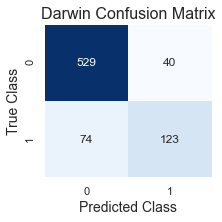

In [155]:
y_pred_Darwin = create_conf_matrix(best_model_Darwin, x_train_Darwin, y_train_Darwin, x_test_Darwin, y_test_Darwin, "Darwin")

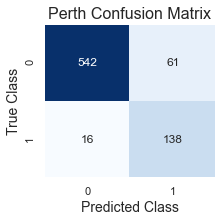

In [156]:
y_pred_Perth = create_conf_matrix(best_model_Perth, x_train_Perth, y_train_Perth, x_test_Perth, y_test_Perth, "Perth")

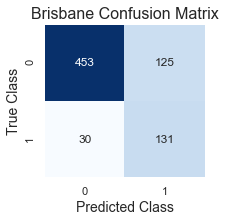

In [157]:
y_pred_Brisbane = create_conf_matrix(best_model_Brisbane, x_train_Brisbane, y_train_Brisbane, x_test_Brisbane, y_test_Brisbane, "Brisbane")

**Evaluation Metrics Reports**

In [158]:
print("===========Classification Report - Darwin============")
print(classification_report(y_test_Darwin, y_pred_Darwin))

print("===========Classification Report - Perth============")
print(classification_report(y_test_Perth, y_pred_Perth))

print("===========Classification Report - Brisbane============")
print(classification_report(y_test_Brisbane, y_pred_Brisbane))

===========Classification Report - Darwin============
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       569
           1       0.75      0.62      0.68       197

    accuracy                           0.85       766
   macro avg       0.82      0.78      0.79       766
weighted avg       0.85      0.85      0.85       766

===========Classification Report - Perth============
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       603
           1       0.69      0.90      0.78       154

    accuracy                           0.90       757
   macro avg       0.83      0.90      0.86       757
weighted avg       0.91      0.90      0.90       757

===========Classification Report - Brisbane============
              precision    recall  f1-score   support

           0       0.94      0.78      0.85       578
           1       0.51      0.81      0.63       161

    accuracy       

**ROC Curve**

In [159]:
def create_roc_curve(best_model, x_train, y_train, x_test, y_test, loc):
    # train model
    best_model.fit(x_train,y_train)
    
    # get predicted probabilities
    y_prob = best_model.predict_proba(x_test)[:,1]
    
    # create true and false positive rates
    false_pos_rate, true_pos_rate, threshold = roc_curve(y_test, y_prob)
    
    # plot ROC curve
    plt.rcParams['figure.figsize'] = (5,5)
    plt.title(loc + " Receiver Operating Characteristic", size=16)
    plt.plot(false_pos_rate, true_pos_rate)
    plt.plot([0,1], ls='--')
    plt.plot([0,0], [1,0], c=".7"), plt.plot([1,1], c=".7")
    plt.ylabel("True Positive Rate", size=14)
    plt.xlabel("False Positive Rate", size=14)
    plt.show()
    
    #calculate area under curve
    roc_auc_scr = roc_auc_score(y_test, y_prob)
    print("The ROC AUC Score for", loc, "is", roc_auc_scr)

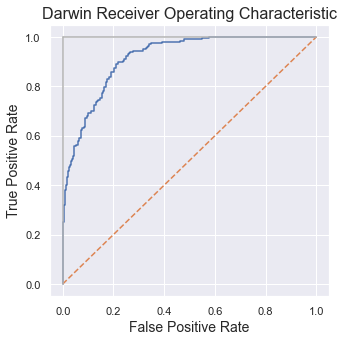

The ROC AUC Score for Darwin is 0.9149010196890083


In [160]:
create_roc_curve(best_model_Darwin, x_train_Darwin, y_train_Darwin, x_test_Darwin, y_test_Darwin, "Darwin")

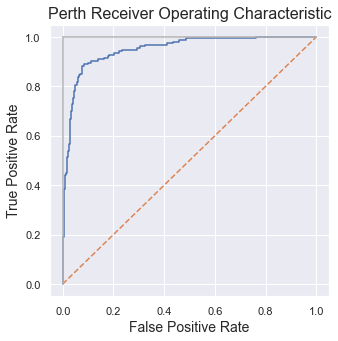

The ROC AUC Score for Perth is 0.9492580388102776


In [161]:
create_roc_curve(best_model_Perth, x_train_Perth, y_train_Perth, x_test_Perth, y_test_Perth, "Perth")

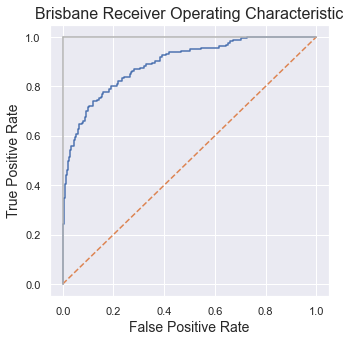

The ROC AUC Score for Brisbane is 0.8914870295944465


In [162]:
create_roc_curve(best_model_Brisbane, x_train_Brisbane, y_train_Brisbane, x_test_Brisbane, y_test_Brisbane, "Brisbane")